## Final Project Submission

Please fill out:
* Student name: Jeff Spagnola
* Student pace: Full Time
* Scheduled project review date/time: 10/7/2020 - 2:00pm
* Instructor name: James Irving
* Blog post URL:


# Global Terrorism: Predicting the Success of Terrorist Attacks

<center><img src="main-image.jpeg" alt="Terrorism Map" height = 250 ></center>

## Introduction

Terrorism is a worldwide problem.  Between 1970 and 2017, there were 181,691 terrorist attacks recorded globally.  Attacks have been recorded on every continent and in over ___ countries.  In the interest of national security, we will analyze terrorist attacks between 1997 and 2017 to figure out the specifc factors that determine whether a terrorist attack will be successeful.  By knowing the patterns, strenghts and weakness of terrorists and terrorist organizations, we can be more prepared to prevent new attacks in the future.  

Throughout the course of this notebook, we will attempt to determine what factors are most important in ensuring the success of a terrorist attack.  Utilizing the OSEMN data science process, we will analyze the data and then employ various machine learning algorithms to determine the importance of features.  


 <div class="alert alert-info" role="alert">
<center><b><u>Defining "Success"</u></b></center>
<u>According to the Global Terrorist Database: </u><br>
Success of a terrorist strike is defined according to the tangible effects of the attack.
Success is not judged in terms of the larger goals of the perpetrators. For example, a
bomb that exploded in a building would be counted as a success even if it did not
succeed in bringing the building down or inducing government repression. <br><br>
The definition of a successful attack depends on the type of attack. Essentially, the
key question is whether or not the attack type took place. If a case has multiple
attack types, it is successful if any of the attack types are successful, with the
exception of assassinations, which are only successful if the intended target is killed.
    </div>

### Import Packages

In [1]:
# General Imports
import numpy as np
import pandas as pd

# Plotting
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import datetime
import missingno as msno
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import plot_confusion_matrix
import shap
shap.initjs()

# Data Preprocessing
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.compose import ColumnTransformer

# Modeling
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

# Model Validation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

# Forces pandas to display all columns
pd.set_option('display.max_columns', None)

from sklearn import set_config
set_config(display = 'diagram')


Bad key "text.kerning_factor" on line 4 in
/Users/spags/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


### Functions

In [3]:
def get_info(df):
    ''' Prints simple info on a dataframe.'''
    print(df.describe())
    print(df.info())
    print(df.isna().sum())
    
    
def get_columns_with_nulls(df):
    '''Iterates through a dataframe and pulls out the columns with null values, 
    as well as the amount of null values in the column.'''
    
    print("Columns with Null Values")
    print("-------------------------")
    for column in df.columns:
        if df[column].isna().sum() > 0:
            print(column, ' = ', df[column].isna().sum())
            

def evaluate_model(model, X_test, y_test):
    '''Evaluates a classification model by displaying a classification report, 
    a confusion matrix plot, and a ROC-AUC plot.'''
    
    # Predictions
    y_hat_test = model.predict(X_test)
      
    # Classification Report
    print('                 Classification Report')
    print('-------------------------------------------------------')
    print(classification_report(y_test, y_hat_test))
    
    # Confusion Matrix Plot
    fig, axes = plt.subplots(figsize = (12, 6), ncols = 2)
    plot_confusion_matrix(model, X_test, y_test, normalize = 'true', cmap = 'Blues', ax = axes[0])
    axes[0].set_title('Confusion Matrix');
    
    # ROC-AUC Curve
    roc__auc_plot = plot_roc_curve(model, X_test, y_test,ax=axes[1])
    axes[1].legend()
    axes[1].plot([0,1],[0,1],ls=':')
    axes[1].grid()
    axes[1].set_title('ROC-AUC Plot') 
    fig.tight_layout()
    plt.show()
    

def get_recall(model, X_test, y_test):
    '''Prints the recall score for a model.'''
    
    # Predictions
    y_hat_test = model.predict(X_test)
    
    # Get Recall Sore
    recall = recall_score(y_test, y_hat_test)
    return recall

def get_precision(model, X_test, y_test):
    '''Prints the precision score for a model.'''
    
    # Predictions
    y_hat_test = model.predict(X_test)
    
    # Get Precision Score
    precision = precision_score(y_test, y_hat_test)
    return precision

def get_accuracy(model, X_test, y_test):
    '''Prints the accuracy score for a model.'''
    
    # Predictions
    y_hat_test = model.predict(X_test)
    
    # Get Precision Score
    accuracy = accuracy_score(y_test, y_hat_test)
    return accuracy

def get_f1_score(model, X_test, y_test):
    '''Prints the F1 score for a model.'''
    
    # Predictions
    y_hat_test = model.predict(X_test)
    
    # Get Precision Score
    f1 = f1_score(y_test, y_hat_test)
    return f1

def get_score_summary(model_list, X_test, y_test):
    '''Takes in a list of models and creates a 
    summary dataframe of scores.'''
    
    reports = []
    for model in model_list:
        # Predictions
        y_hat_test = model.predict(X_test)
    
        # Get Report
        report_dict = classification_report(y_test, y_hat_test, output_dict=True)
        reports.append(report_dict)
        
    df = pd.DataFrame(reports).transpose()
    return df

## Obtain

### Import Data

In [4]:
# Importing the dataset

df = pd.read_csv('global_terrorism.csv', engine = 'python')
print(df.shape)
df.head()

(181691, 135)


,eventid,iyear,imonth,iday,approxdate,extended,resolution,country,country_txt,region,region_txt,provstate,city,latitude,longitude,specificity,vicinity,location,summary,crit1,crit2,crit3,doubtterr,alternative,alternative_txt,multiple,success,suicide,attacktype1,attacktype1_txt,attacktype2,attacktype2_txt,attacktype3,attacktype3_txt,targtype1,targtype1_txt,targsubtype1,targsubtype1_txt,corp1,target1,natlty1,natlty1_txt,targtype2,targtype2_txt,targsubtype2,targsubtype2_txt,corp2,target2,natlty2,natlty2_txt,targtype3,targtype3_txt,targsubtype3,targsubtype3_txt,corp3,target3,natlty3,natlty3_txt,gname,gsubname,gname2,gsubname2,gname3,gsubname3,motive,guncertain1,guncertain2,guncertain3,individual,nperps,nperpcap,claimed,claimmode,claimmode_txt,claim2,claimmode2,claimmode2_txt,claim3,claimmode3,claimmode3_txt,compclaim,weaptype1,weaptype1_txt,weapsubtype1,weapsubtype1_txt,weaptype2,weaptype2_txt,weapsubtype2,weapsubtype2_txt,weaptype3,weaptype3_txt,weapsubtype3,weapsubtype3_txt,weaptype4,weaptype4_txt,weapsubtype4,weapsubtype4_txt,weapdetail,nkill,nkillus,nkillter,nwound,nwoundus,nwoundte,property,propextent,propextent_txt,propvalue,propcomment,ishostkid,nhostkid,nhostkidus,nhours,ndays,divert,kidhijcountry,ransom,ransomamt,ransomamtus,ransompaid,ransompaidus,ransomnote,hostkidoutcome,hostkidoutcome_txt,nreleased,addnotes,scite1,scite2,scite3,dbsource,INT_LOG,INT_IDEO,INT_MISC,INT_ANY,related
0,197000000001,1970,7,2,NaN,0,NaN,58,Dominican Republic,2,Central America & Caribbean,NaN,Santo Domingo,18.456792,-69.951164,1.0,0,NaN,NaN,1,1,1,0.0,NaN,NaN,0.0,1,0,1,Assassination,NaN,NaN,NaN,NaN,14,Private Citizens & Property,68.0,Named Civilian,NaN,Julio Guzman,58.0,Dominican Republic,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MANO-D,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13,Unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,0.0,NaN,NaN,0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PGIS,0,0,0,0,NaN
1,197000000002,1970,0,0,NaN,0,NaN,130,Mexico,1,North America,Federal,Mexico city,19.371887,-99.086624,1.0,0,NaN,NaN,1,1,1,0.0,NaN,NaN,0.0,1,0,6,Hostage Taking (Kidnapping),NaN,NaN,NaN,NaN,7,Government (Diplomatic),45.0,"Diplomatic Personnel (outside of embassy, cons...",Belgian Ambassador Daughter,"Nadine Chaval, daughter",21.0,Belgium,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23rd of September Communist League,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13,Unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0,NaN,NaN,NaN,NaN,1.0,1.0,0.0,NaN,NaN,NaN,Mexico,1.0,800000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PGIS,0,1,1,1,NaN
2,197001000001,1970,1,0,NaN,0,NaN,160,Philippines,5,Southeast Asia,Tarlac,Unknown,15.478598,120.599741,4.0,0,NaN,NaN,1,1,1,0.0,NaN,NaN,0.0,1,0,1,Assassination,NaN,NaN,NaN,NaN,10,Journalists & Media,54.0,Radio Journalist/Staff/Facility,Voice of America,Employee,217.0,United States,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unknown,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13,Unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,0.0,NaN,NaN,0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN
3,197001000002,1970,1,0,NaN,0,NaN,78,Greece,8,Western Europe,Attica,Athens,37.997490,23.762728,1.0,0,NaN,NaN,1,1,1,0.0,NaN,NaN,0.0,1,0,3,Bombing/Explosion,NaN,NaN,NaN,NaN,7,Government (Diplomatic),46.0,Embassy/Consulate,NaN,U.S. Embassy,217.0,United States,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unknown,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,Explosives,16.0,Unknown Explosive Type,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Explosive,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN

## Scrub

In [5]:
# Getting a bunch of info on the dataset

get_info(df)

            eventid          iyear         imonth           iday  \
count  1.816910e+05  181691.000000  181691.000000  181691.000000   
mean   2.002705e+11    2002.638997       6.467277      15.505644   
std    1.325957e+09      13.259430       3.388303       8.814045   
min    1.970000e+11    1970.000000       0.000000       0.000000   
25%    1.991021e+11    1991.000000       4.000000       8.000000   
50%    2.009022e+11    2009.000000       6.000000      15.000000   
75%    2.014081e+11    2014.000000       9.000000      23.000000   
max    2.017123e+11    2017.000000      12.000000      31.000000   

            extended        country         region       latitude  \
count  181691.000000  181691.000000  181691.000000  177135.000000   
mean        0.045346     131.968501       7.160938      23.498343   
std         0.208063     112.414535       2.933408      18.569242   
min         0.000000       4.000000       1.000000     -53.154613   
25%         0.000000      78.000000       

eventid            0
iyear              0
imonth             0
iday               0
approxdate    172452
               ...  
INT_LOG            0
INT_IDEO           0
INT_MISC           0
INT_ANY            0
related       156653
Length: 135, dtype: int64


### Prune the Dataset

 <div class="alert alert-info" role="alert">
    <b><u>Let's see if we can prune this dataset by checking to see: </u></b><br><br>
 1. Can we focus on a specific time period?<br>
 2. Are there any irrelevant columns?<br>
 3. Are there any columns made irrelevant by null values?<br>
 4. Can any columns be condensed? <br>
</div>

#### Focus On Last 20 Years

 <div class="alert alert-info" role="alert">
 The dataset contains information on terrorist attacks recorded between 1970 and 2017.  In order to cut down on computing time, we will focus only on the most recent 20 years of data: 1997 to 2017.  
    
 </div>

In [6]:
# find the minumum and maximum year

print(df['iyear'].min())
print(df['iyear'].max())

1970
2017


In [7]:
# filtering out the most recent 20 years from the overall dataset

df = df[df['iyear'] >= 1997]
print(df.shape)
df.head()

(117381, 135)


,eventid,iyear,imonth,iday,approxdate,extended,resolution,country,country_txt,region,region_txt,provstate,city,latitude,longitude,specificity,vicinity,location,summary,crit1,crit2,crit3,doubtterr,alternative,alternative_txt,multiple,success,suicide,attacktype1,attacktype1_txt,attacktype2,attacktype2_txt,attacktype3,attacktype3_txt,targtype1,targtype1_txt,targsubtype1,targsubtype1_txt,corp1,target1,natlty1,natlty1_txt,targtype2,targtype2_txt,targsubtype2,targsubtype2_txt,corp2,target2,natlty2,natlty2_txt,targtype3,targtype3_txt,targsubtype3,targsubtype3_txt,corp3,target3,natlty3,natlty3_txt,gname,gsubname,gname2,gsubname2,gname3,gsubname3,motive,guncertain1,guncertain2,guncertain3,individual,nperps,nperpcap,claimed,claimmode,claimmode_txt,claim2,claimmode2,claimmode2_txt,claim3,claimmode3,claimmode3_txt,compclaim,weaptype1,weaptype1_txt,weapsubtype1,weapsubtype1_txt,weaptype2,weaptype2_txt,weapsubtype2,weapsubtype2_txt,weaptype3,weaptype3_txt,weapsubtype3,weapsubtype3_txt,weaptype4,weaptype4_txt,weapsubtype4,weapsubtype4_txt,weapdetail,nkill,nkillus,nkillter,nwound,nwoundus,nwoundte,property,propextent,propextent_txt,propvalue,propcomment,ishostkid,nhostkid,nhostkidus,nhours,ndays,divert,kidhijcountry,ransom,ransomamt,ransomamtus,ransompaid,ransompaidus,ransomnote,hostkidoutcome,hostkidoutcome_txt,nreleased,addnotes,scite1,scite2,scite3,dbsource,INT_LOG,INT_IDEO,INT_MISC,INT_ANY,related
64310,199701010001,1997,1,1,NaN,0,NaN,141,Nepal,6,South Asia,Central,Bethan,27.493003,85.824033,1.0,1,NaN,NaN,1,1,1,-9.0,NaN,NaN,0.0,1,0,2,Armed Assault,NaN,NaN,NaN,NaN,3,Police,22.0,"Police Building (headquarters, station, school)",Government,Police Department,141.0,Nepal,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unknown,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0,300.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,Firearms,5.0,Unknown Gun Type,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Firearm,5.0,NaN,NaN,2.0,NaN,NaN,1,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PGIS,-9,-9,0,-9,NaN
64311,199701010002,1997,1,1,NaN,0,NaN,155,West Bank and Gaza Strip,10,Middle East & North Africa,West Bank,Hebron,31.530243,35.094162,1.0,0,NaN,NaN,1,1,1,-9.0,NaN,NaN,0.0,1,0,2,Armed Assault,NaN,NaN,NaN,NaN,14,Private Citizens & Property,74.0,Marketplace/Plaza/Square,NaN,Market Place,155.0,West Bank and Gaza Strip,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Jewish Extremists,Settlers,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,Firearms,2.0,Automatic or Semi-Automatic Rifle,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,M-16,0.0,NaN,NaN,7.0,NaN,NaN,1,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PGIS,-9,-9,0,-9,NaN
64312,199701010003,1997,1,1,NaN,0,NaN,217,United States,1,North America,Oklahoma,Tulsa,36.149745,-95.993334,1.0,0,NaN,NaN,1,1,1,-9.0,NaN,NaN,1.0,1,0,7,Facility/Infrastructure Attack,NaN,NaN,NaN,NaN,5,Abortion Related,40.0,Clinics,Reproductive Services,Abortion Clinic,217.0,United States,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Anti-Abortion extremists,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,1,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8,Incendiary,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Incendiary,0.0,NaN,NaN,0.0,NaN,NaN,1,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PGIS,-9,-9,0,-9,"199701010003, 199701010004, 199701010005"
64313,199701010004,1997,1,1,NaN,0,NaN,217,United States,1,North America,Oklahoma,Tulsa,36.149745,-95.993334,1.0,0,NaN,NaN,1,1,1,-9.0,NaN,NaN,1.0,1,0,7,Facility/Infrastructure Attack,NaN,NaN,NaN,NaN,5,Abortion Related,40.0,Clinics,Reproductive Services,Abortion Clinic,217.0,United States,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Anti-Abortion extremists,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,1,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8,Incen

 <div class="alert alert-info" role="alert">
 We've managed to cut the size of the dataframe down by 64k rows.  
    
   </div>

### Remove Irrelevant Columns

#### Column Descriptions

 <div class="alert alert-info" role="alert">
There is a comprehensive guide to navigating the Global Terrorism Database <a href="https://www.start.umd.edu/gtd/downloads/Codebook.pdf">here</a>.  This guide includes a list of all the columns with detailed descriptions of each.  For the sake of time, we can refer to this guide when analyzing the columns and their values.  
</div>

#### Drop Irrelevant Columns

In [8]:
# Checking how many columns we're working with

len(df.columns)

135

In [9]:
# Checking out  the full list of columns

columns = []
for col in df.columns:
    columns.append(col)
    
columns

['eventid',
 'iyear',
 'imonth',
 'iday',
 'approxdate',
 'extended',
 'resolution',
 'country',
 'country_txt',
 'region',
 'region_txt',
 'provstate',
 'city',
 'latitude',
 'longitude',
 'specificity',
 'vicinity',
 'location',
 'summary',
 'crit1',
 'crit2',
 'crit3',
 'doubtterr',
 'alternative',
 'alternative_txt',
 'multiple',
 'success',
 'suicide',
 'attacktype1',
 'attacktype1_txt',
 'attacktype2',
 'attacktype2_txt',
 'attacktype3',
 'attacktype3_txt',
 'targtype1',
 'targtype1_txt',
 'targsubtype1',
 'targsubtype1_txt',
 'corp1',
 'target1',
 'natlty1',
 'natlty1_txt',
 'targtype2',
 'targtype2_txt',
 'targsubtype2',
 'targsubtype2_txt',
 'corp2',
 'target2',
 'natlty2',
 'natlty2_txt',
 'targtype3',
 'targtype3_txt',
 'targsubtype3',
 'targsubtype3_txt',
 'corp3',
 'target3',
 'natlty3',
 'natlty3_txt',
 'gname',
 'gsubname',
 'gname2',
 'gsubname2',
 'gname3',
 'gsubname3',
 'motive',
 'guncertain1',
 'guncertain2',
 'guncertain3',
 'individual',
 'nperps',
 'nperpcap',
 

In [10]:
# dropping any columns not relevant to creating the classification model

to_drop = ['eventid', 'dbsource', 'scite1', 'scite2', 'scite3', 'addnotes', 'propcomment',
           'alternative', 'alternative_txt', 'doubtterr', 'summary', 'approxdate', 'related']

df.drop(to_drop, axis = 1, inplace = True)
print(df.shape)

(117381, 122)


#### Drop Columns with Excessive Nulls

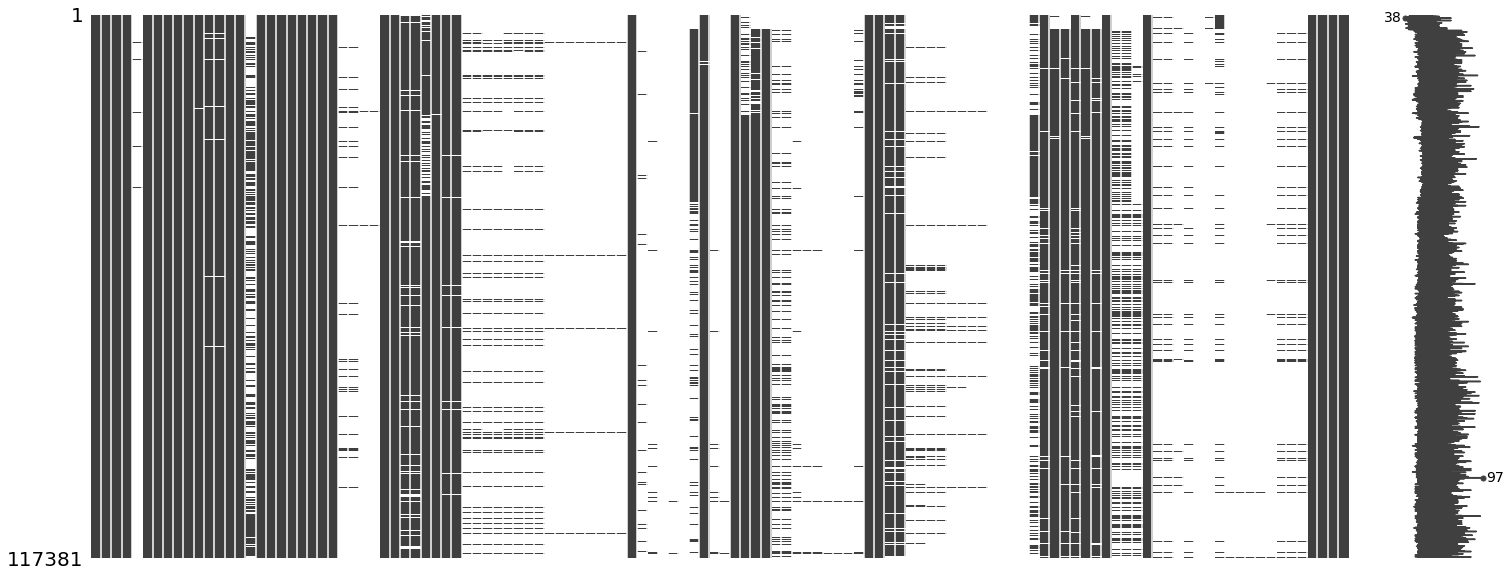

In [11]:
# Plotting the null values

msno.matrix(df)

In [12]:
# Getting a printout of columns with null values

print('Columns with Null Values')
print('------------------------')
null_cols = []
null_drops = []
for col in df.columns:
    if df[col].isna().sum() > 0:
        null_cols.append(col)
        nulls = df[col].isna().sum()
        null_ratio = round(nulls/len(df), 2)  
        print(col, ' - ', nulls, ' - ', null_ratio)
        if null_ratio > 0.9:
            null_drops.append(col)
            

Columns with Null Values
------------------------
resolution  -  116342  -  0.99
provstate  -  64  -  0.0
city  -  434  -  0.0
latitude  -  1135  -  0.01
longitude  -  1135  -  0.01
specificity  -  6  -  0.0
location  -  62713  -  0.53
multiple  -  1  -  0.0
attacktype2  -  111117  -  0.95
attacktype2_txt  -  111117  -  0.95
attacktype3  -  116956  -  1.0
attacktype3_txt  -  116956  -  1.0
targsubtype1  -  7314  -  0.06
targsubtype1_txt  -  7314  -  0.06
corp1  -  12090  -  0.1
target1  -  204  -  0.0
natlty1  -  1178  -  0.01
natlty1_txt  -  1178  -  0.01
targtype2  -  106951  -  0.91
targtype2_txt  -  106951  -  0.91
targsubtype2  -  107233  -  0.91
targsubtype2_txt  -  107233  -  0.91
corp2  -  107716  -  0.92
target2  -  106993  -  0.91
natlty2  -  107202  -  0.91
natlty2_txt  -  107202  -  0.91
targtype3  -  116338  -  0.99
targtype3_txt  -  116338  -  0.99
targsubtype3  -  116391  -  0.99
targsubtype3_txt  -  116391  -  0.99
corp3  -  116442  -  0.99
target3  -  116337  -  0.99
n

In [13]:
# Coming up with null counts and what columns can be dropped

print('Columns with Null Values: ', len(null_cols))
print('Columns with Excessive Nulls: ',len(null_drops))
null_drops

Columns with Null Values:  95
Columns with Excessive Nulls:  61


['resolution',
 'attacktype2',
 'attacktype2_txt',
 'attacktype3',
 'attacktype3_txt',
 'targtype2',
 'targtype2_txt',
 'targsubtype2',
 'targsubtype2_txt',
 'corp2',
 'target2',
 'natlty2',
 'natlty2_txt',
 'targtype3',
 'targtype3_txt',
 'targsubtype3',
 'targsubtype3_txt',
 'corp3',
 'target3',
 'natlty3',
 'natlty3_txt',
 'gsubname',
 'gname2',
 'gsubname2',
 'gname3',
 'gsubname3',
 'guncertain2',
 'guncertain3',
 'claim2',
 'claimmode2',
 'claimmode2_txt',
 'claim3',
 'claimmode3',
 'claimmode3_txt',
 'compclaim',
 'weaptype2',
 'weaptype2_txt',
 'weapsubtype2',
 'weapsubtype2_txt',
 'weaptype3',
 'weaptype3_txt',
 'weapsubtype3',
 'weapsubtype3_txt',
 'weaptype4',
 'weaptype4_txt',
 'weapsubtype4',
 'weapsubtype4_txt',
 'nhostkid',
 'nhostkidus',
 'nhours',
 'ndays',
 'divert',
 'kidhijcountry',
 'ransomamt',
 'ransomamtus',
 'ransompaid',
 'ransompaidus',
 'ransomnote',
 'hostkidoutcome',
 'hostkidoutcome_txt',
 'nreleased']

In [14]:
# Dropping columns

df.drop(null_drops, axis = 1, inplace = True)
print(df.shape)

(117381, 61)


#### Dropping Redundant Columns

 <div class="alert alert-info" role="alert">
We can drop any column that carries the same information as other columns.  For example, country spans 2 columns: 1 label encoded and 1 text.
   </div>

In [15]:
df.head()

,iyear,imonth,iday,extended,country,country_txt,region,region_txt,provstate,city,latitude,longitude,specificity,vicinity,location,crit1,crit2,crit3,multiple,success,suicide,attacktype1,attacktype1_txt,targtype1,targtype1_txt,targsubtype1,targsubtype1_txt,corp1,target1,natlty1,natlty1_txt,gname,motive,guncertain1,individual,nperps,nperpcap,claimed,claimmode,claimmode_txt,weaptype1,weaptype1_txt,weapsubtype1,weapsubtype1_txt,weapdetail,nkill,nkillus,nkillter,nwound,nwoundus,nwoundte,property,propextent,propextent_txt,propvalue,ishostkid,ransom,INT_LOG,INT_IDEO,INT_MISC,INT_ANY
64310,1997,1,1,0,141,Nepal,6,South Asia,Central,Bethan,27.493003,85.824033,1.0,1,NaN,1,1,1,0.0,1,0,2,Armed Assault,3,Police,22.0,"Police Building (headquarters, station, school)",Government,Police Department,141.0,Nepal,Unknown,NaN,0.0,0,300.0,NaN,NaN,NaN,NaN,5,Firearms,5.0,Unknown Gun Type,Firearm,5.0,NaN,NaN,2.0,NaN,NaN,1,NaN,NaN,NaN,0.0,0.0,-9,-9,0,-9
64311,1997,1,1,0,155,West Bank and Gaza Strip,10,Middle East & North Africa,West Bank,Hebron,31.530243,35.094162,1.0,0,NaN,1,1,1,0.0,1,0,2,Armed Assault,14,Private Citizens & Property,74.0,Marketplace/Plaza/Square,NaN,Market Place,155.0,West Bank and Gaza Strip,Jewish Extremists,NaN,0.0,0,1.0,NaN,NaN,NaN,NaN,5,Firearms,2.0,Automatic or Semi-Automatic Rifle,M-16,0.0,NaN,NaN,7.0,NaN,NaN,1,NaN,NaN,NaN,0.0,0.0,-9,-9,0,-9
64312,1997,1,1,0,217,United States,1,North America,Oklahoma,Tulsa,36.149745,-95.993334,1.0,0,NaN,1,1,1,1.0,1,0,7,Facility/Infrastructure Attack,5,Abortion Related,40.0,Clinics,Reproductive Services,Abortion Clinic,217.0,United States,Anti-Abortion extremists,NaN,0.0,1,NaN,1.0,NaN,NaN,NaN,8,Incendiary,NaN,NaN,Incendiary,0.0,NaN,NaN,0.0,NaN,NaN,1,NaN,NaN,NaN,0.0,0.0,-9,-9,0,-9
64313,1997,1,1,0,217,United States,1,North America,Oklahoma,Tulsa,36.149745,-95.993334,1.0,0,NaN,1,1,1,1.0,1,0,7,Facility/Infrastructure Attack,5,Abortion Related,40.0,Clinics,Reproductive Services,Abortion Clinic,217.0,United States,Anti-Abortion extremists,NaN,0.0,1,NaN,1.0,NaN,NaN,NaN,8,Incendiary,NaN,NaN,Incendiary,0.0,NaN,NaN,0.0,NaN,NaN,1,NaN,NaN,NaN,0.0,0.0,-9,-9,0,-9
64314,1997,1,1,0,217,United States,1,North America,Oklahoma,Tulsa,36.149745,-95.993334,1.0,0,NaN,1,1,1,1.0,1,0,7,Facility/Infrastructure Attack,5,Abortion Related,40.0,Clinics,Reproductive Services,Abortion Clinic,217.0,United States,Anti-Abortion extremists,NaN,0.0,1,NaN,1.0,NaN,NaN,NaN,8,Incendiary,NaN,NaN,Incendiary,0.0,NaN,NaN,0.0,NaN,NaN,1,NaN,NaN,NaN,0.0,0.0,-9,-9,0,-9


> We can make the choice to keep the _txt colums and remove the corresponding label encoded columns.  The concept here is to make the dataframes easier to interpret.  

In [16]:
more_drops = ['country', 'region', 'attacktype1', 'targtype1', 'targsubtype1', 'natlty1', 'claimmode', 
              'weaptype1', 'weapsubtype1', 'propextent']

df.drop(more_drops, axis = 1, inplace = True)
print(df.shape)

(117381, 51)


### Condensing Columns By Category

In [17]:
df.head()

,iyear,imonth,iday,extended,country_txt,region_txt,provstate,city,latitude,longitude,specificity,vicinity,location,crit1,crit2,crit3,multiple,success,suicide,attacktype1_txt,targtype1_txt,targsubtype1_txt,corp1,target1,natlty1_txt,gname,motive,guncertain1,individual,nperps,nperpcap,claimed,claimmode_txt,weaptype1_txt,weapsubtype1_txt,weapdetail,nkill,nkillus,nkillter,nwound,nwoundus,nwoundte,property,propextent_txt,propvalue,ishostkid,ransom,INT_LOG,INT_IDEO,INT_MISC,INT_ANY
64310,1997,1,1,0,Nepal,South Asia,Central,Bethan,27.493003,85.824033,1.0,1,NaN,1,1,1,0.0,1,0,Armed Assault,Police,"Police Building (headquarters, station, school)",Government,Police Department,Nepal,Unknown,NaN,0.0,0,300.0,NaN,NaN,NaN,Firearms,Unknown Gun Type,Firearm,5.0,NaN,NaN,2.0,NaN,NaN,1,NaN,NaN,0.0,0.0,-9,-9,0,-9
64311,1997,1,1,0,West Bank and Gaza Strip,Middle East & North Africa,West Bank,Hebron,31.530243,35.094162,1.0,0,NaN,1,1,1,0.0,1,0,Armed Assault,Private Citizens & Property,Marketplace/Plaza/Square,NaN,Market Place,West Bank and Gaza Strip,Jewish Extremists,NaN,0.0,0,1.0,NaN,NaN,NaN,Firearms,Automatic or Semi-Automatic Rifle,M-16,0.0,NaN,NaN,7.0,NaN,NaN,1,NaN,NaN,0.0,0.0,-9,-9,0,-9
64312,1997,1,1,0,United States,North America,Oklahoma,Tulsa,36.149745,-95.993334,1.0,0,NaN,1,1,1,1.0,1,0,Facility/Infrastructure Attack,Abortion Related,Clinics,Reproductive Services,Abortion Clinic,United States,Anti-Abortion extremists,NaN,0.0,1,NaN,1.0,NaN,NaN,Incendiary,NaN,Incendiary,0.0,NaN,NaN,0.0,NaN,NaN,1,NaN,NaN,0.0,0.0,-9,-9,0,-9
64313,1997,1,1,0,United States,North America,Oklahoma,Tulsa,36.149745,-95.993334,1.0,0,NaN,1,1,1,1.0,1,0,Facility/Infrastructure Attack,Abortion Related,Clinics,Reproductive Services,Abortion Clinic,United States,Anti-Abortion extremists,NaN,0.0,1,NaN,1.0,NaN,NaN,Incendiary,NaN,Incendiary,0.0,NaN,NaN,0.0,NaN,NaN,1,NaN,NaN,0.0,0.0,-9,-9,0,-9
64314,1997,1,1,0,United States,North America,Oklahoma,Tulsa,36.149745,-95.993334,1.0,0,NaN,1,1,1,1.0,1,0,Facility/Infrastructure Attack,Abortion Related,Clinics,Reproductive Services,Abortion Clinic,United States,Anti-Abortion extremists,NaN,0.0,1,NaN,1.0,NaN,NaN,Incendiary,NaN,Incendiary,0.0,NaN,NaN,0.0,NaN,NaN,1,NaN,NaN,0.0,0.0,-9,-9,0,-9


In [18]:
# Printing the remaining columns

for col in df.columns:
    print(col)

iyear
imonth
iday
extended
country_txt
region_txt
provstate
city
latitude
longitude
specificity
vicinity
location
crit1
crit2
crit3
multiple
success
suicide
attacktype1_txt
targtype1_txt
targsubtype1_txt
corp1
target1
natlty1_txt
gname
motive
guncertain1
individual
nperps
nperpcap
claimed
claimmode_txt
weaptype1_txt
weapsubtype1_txt
weapdetail
nkill
nkillus
nkillter
nwound
nwoundus
nwoundte
property
propextent_txt
propvalue
ishostkid
ransom
INT_LOG
INT_IDEO
INT_MISC
INT_ANY


In [19]:
# Separating columns by category in order to more easily go through them and see what can be dropped/condensed

time_columns = ['iyear', 'imonth', 'iday', 'extended']

geo_columns = ['country_txt', 'region_txt', 'provstate', 'city', 'latitude', 'longitude',
               'vicinity', 'location']

incident_columns = ['crit1', 'crit2', 'crit3', 'multiple']

attack_columns = ['success', 'suicide', 'attacktype1_txt']

weapon_columns = ['weaptype1_txt', 'weapsubtype1_txt', 'weapdetail']

target_columns = ['targtype1_txt', 'targsubtype1_txt', 'corp1',
                  'target1', 'natlty1_txt']

perp_columns = ['gname', 'motive', 'guncertain1', 'individual', 'nperps', 
                'nperpcap', 'claimed', 'claimmode_txt']

casualy_columns = ['nkill', 'nkillus', 'nkillter', 'nwound', 'nwoundus', 'nwoundte', 'property', 
                   'propextent_txt', 'propvalue', 'ishostkid', 'ransom']

misc_columns = ['INT_LOG', 'INT_IDEO', 'INT_MISC', 'INT_ANY']

#### Time Indicators

 <div class="alert alert-info" role="alert">
All of the time-based columns are relevant and can remain in the dataset.  
    </div>

In [20]:
# Taking a look at the time columns

df[time_columns].head()

,iyear,imonth,iday,extended
64310,1997,1,1,0
64311,1997,1,1,0
64312,1997,1,1,0
64313,1997,1,1,0
64314,1997,1,1,0


In [21]:
# Caught a few 0's in this one

df['iday'].value_counts()

15    4086
3     3998
1     3951
11    3950
2     3949
4     3940
14    3933
27    3929
13    3914
24    3894
9     3886
5     3882
7     3880
28    3877
8     3873
12    3868
10    3846
16    3816
21    3799
18    3796
25    3790
6     3787
20    3778
19    3758
22    3736
23    3726
17    3714
26    3696
29    3608
30    3341
31    2109
0      271
Name: iday, dtype: int64

In [22]:
# Replace 0's with nan's

df['iday'].replace(0, np.nan, inplace = True)

In [23]:
# Checking to see this worked

df['iday'].value_counts()

15.0    4086
3.0     3998
1.0     3951
11.0    3950
2.0     3949
4.0     3940
14.0    3933
27.0    3929
13.0    3914
24.0    3894
9.0     3886
5.0     3882
7.0     3880
28.0    3877
8.0     3873
12.0    3868
10.0    3846
16.0    3816
21.0    3799
18.0    3796
25.0    3790
6.0     3787
20.0    3778
19.0    3758
22.0    3736
23.0    3726
17.0    3714
26.0    3696
29.0    3608
30.0    3341
31.0    2109
Name: iday, dtype: int64

#### Geographic Indicators

In [24]:
# Checking out geographic colums

df[geo_columns].head()

,country_txt,region_txt,provstate,city,latitude,longitude,vicinity,location
64310,Nepal,South Asia,Central,Bethan,27.493003,85.824033,1,NaN
64311,West Bank and Gaza Strip,Middle East & North Africa,West Bank,Hebron,31.530243,35.094162,0,NaN
64312,United States,North America,Oklahoma,Tulsa,36.149745,-95.993334,0,NaN
64313,United States,North America,Oklahoma,Tulsa,36.149745,-95.993334,0,NaN
64314,United States,North America,Oklahoma,Tulsa,36.149745,-95.993334,0,NaN


In [25]:
# Checking the value counts 

for col in df[geo_columns].columns:
    print(df[col].value_counts())

Iraq                 24515
Pakistan             12833
Afghanistan          12618
India                 9284
Philippines           5026
                     ...  
Togo                     1
Equatorial Guinea        1
Romania                  1
International            1
Lithuania                1
Name: country_txt, Length: 175, dtype: int64
Middle East & North Africa     42189
South Asia                     38063
Sub-Saharan Africa             13553
Southeast Asia                  9860
Eastern Europe                  4504
Western Europe                  3926
South America                   3524
North America                    878
Central Asia                     326
East Asia                        251
Central America & Caribbean      215
Australasia & Oceania             92
Name: region_txt, dtype: int64
Baghdad                7604
Balochistan            3666
Saladin                3405
Al Anbar               3296
Nineveh                3237
                       ... 
El-Oued (Provin

In [26]:
# Checking to see if we can prune the countries a bit

active_countries = []
for i in df['country_txt'].value_counts():
    if i > 10:
        active_countries.append(i)
        
len(active_countries)

# Still seems like too many values

125

In [27]:
# Looks like a keeper.

df['region_txt'].value_counts()

Middle East & North Africa     42189
South Asia                     38063
Sub-Saharan Africa             13553
Southeast Asia                  9860
Eastern Europe                  4504
Western Europe                  3926
South America                   3524
North America                    878
Central Asia                     326
East Asia                        251
Central America & Caribbean      215
Australasia & Oceania             92
Name: region_txt, dtype: int64

In [28]:
# Take the weird -9's out of 'vicinity column'

df['vicinity'].replace(-9, np.nan, inplace = True)

In [29]:
# Drop the other geographic location columns

geo_drops = ['country_txt', 'provstate', 'city']

df.drop(geo_drops, axis = 1, inplace = True)
df.shape

(117381, 48)

In [30]:
# Looks like 'location' can be dropped as well.

df.drop('location', axis = 1, inplace = True)
df.shape

(117381, 47)

#### Attack Columns

 <div class="alert alert-info" role="alert">
These all look good for now. 
    </div>

In [31]:
# Checking out attack columns

df[attack_columns].head()

,success,suicide,attacktype1_txt
64310,1,0,Armed Assault
64311,1,0,Armed Assault
64312,1,0,Facility/Infrastructure Attack
64313,1,0,Facility/Infrastructure Attack
64314,1,0,Facility/Infrastructure Attack


In [32]:
# Checking the value counts

df['attacktype1_txt'].value_counts()

Bombing/Explosion                      61178
Armed Assault                          27874
Hostage Taking (Kidnapping)             8485
Assassination                           7452
Facility/Infrastructure Attack          5982
Unknown                                 5015
Unarmed Assault                          685
Hostage Taking (Barricade Incident)      371
Hijacking                                339
Name: attacktype1_txt, dtype: int64

In [33]:
# Shortening values

for i in df['attacktype1_txt']:
    if i == 'Bombing/Explosion':
        df['attacktype1_txt'].replace(i, 'Bombing', inplace = True)
    elif i == 'Hostage Taking (Kidnapping)':
        df['attacktype1_txt'].replace(i, 'Kidnapping', inplace = True)
    elif i == 'Facility/Infrastructure Attack':
        df['attacktype1_txt'].replace(i, 'Facility/Infrastructure', inplace = True)
    elif i == 'Hostage Taking (Barricade Incident)':
        df['attacktype1_txt'].replace(i, 'Barricading', inplace = True)
    else: 
        pass

In [34]:
# Making sure the shortening worked

df['attacktype1_txt'].value_counts()

Bombing                    61178
Armed Assault              27874
Kidnapping                  8485
Assassination               7452
Facility/Infrastructure     5982
Unknown                     5015
Unarmed Assault              685
Barricading                  371
Hijacking                    339
Name: attacktype1_txt, dtype: int64

#### Weapon Columns

In [35]:
# Checking out the weapons columns

df[weapon_columns].head()

,weaptype1_txt,weapsubtype1_txt,weapdetail
64310,Firearms,Unknown Gun Type,Firearm
64311,Firearms,Automatic or Semi-Automatic Rifle,M-16
64312,Incendiary,NaN,Incendiary
64313,Incendiary,NaN,Incendiary
64314,Incendiary,NaN,Incendiary


In [36]:
# Checking the values for these columns.  Look's like I can just stick with the weaptype1_txt column.

for col in df[weapon_columns].columns:
    print(df[col].value_counts())

Explosives                                                                     65178
Firearms                                                                       34313
Unknown                                                                         9209
Incendiary                                                                      5648
Melee                                                                           2447
Chemical                                                                         235
Vehicle (not to include vehicle-borne explosives, i.e., car or truck bombs)      110
Sabotage Equipment                                                               106
Other                                                                             84
Biological                                                                        27
Fake Weapons                                                                      13
Radiological                                                     

##### Weapon Type Alteration

In [37]:
# Checking weapon type value counts

df['weaptype1_txt'].value_counts()

Explosives                                                                     65178
Firearms                                                                       34313
Unknown                                                                         9209
Incendiary                                                                      5648
Melee                                                                           2447
Chemical                                                                         235
Vehicle (not to include vehicle-borne explosives, i.e., car or truck bombs)      110
Sabotage Equipment                                                               106
Other                                                                             84
Biological                                                                        27
Fake Weapons                                                                      13
Radiological                                                     

In [38]:
# Shortening the Vehicle values

for i in df['weaptype1_txt']:
    if i == 'Vehicle (not to include vehicle-borne explosives, i.e., car or truck bombs)':
        df['weaptype1_txt'].replace(i, 'Vehicle', inplace = True)

In [39]:
# Making sure it worked

df['weaptype1_txt'].value_counts()

Explosives            65178
Firearms              34313
Unknown                9209
Incendiary             5648
Melee                  2447
Chemical                235
Vehicle                 110
Sabotage Equipment      106
Other                    84
Biological               27
Fake Weapons             13
Radiological             11
Name: weaptype1_txt, dtype: int64

##### Drop Columns

In [40]:
# Dropping columns

df.drop(columns = ['weapsubtype1_txt', 'weapdetail'], axis = 1, inplace = True)
df.shape

(117381, 45)

#### Target Columns

In [41]:
# Checking the target columns 

df[target_columns].head()

,targtype1_txt,targsubtype1_txt,corp1,target1,natlty1_txt
64310,Police,"Police Building (headquarters, station, school)",Government,Police Department,Nepal
64311,Private Citizens & Property,Marketplace/Plaza/Square,NaN,Market Place,West Bank and Gaza Strip
64312,Abortion Related,Clinics,Reproductive Services,Abortion Clinic,United States
64313,Abortion Related,Clinics,Reproductive Services,Abortion Clinic,United States
64314,Abortion Related,Clinics,Reproductive Services,Abortion Clinic,United States


In [42]:
# Checking all the value counts

for col in df[target_columns].columns:
    print(df[col].value_counts())

Private Citizens & Property       32169
Military                          18925
Police                            17177
Government (General)              13045
Business                           9716
Unknown                            5246
Transportation                     3447
Religious Figures/Institutions     3272
Educational Institution            3076
Utilities                          2417
Terrorists/Non-State Militia       2350
Journalists & Media                1522
Government (Diplomatic)            1413
Violent Political Party            1194
NGO                                 706
Telecommunication                   588
Airports & Aircraft                 400
Tourists                            211
Food or Water Supply                160
Maritime                            157
Other                               122
Abortion Related                     68
Name: targtype1_txt, dtype: int64
Unnamed Civilian/Unspecified                               10142
Police Security Force

##### Target Type Column Alterations

In [43]:
# Checking value counts 

df['targtype1_txt'].value_counts()

Private Citizens & Property       32169
Military                          18925
Police                            17177
Government (General)              13045
Business                           9716
Unknown                            5246
Transportation                     3447
Religious Figures/Institutions     3272
Educational Institution            3076
Utilities                          2417
Terrorists/Non-State Militia       2350
Journalists & Media                1522
Government (Diplomatic)            1413
Violent Political Party            1194
NGO                                 706
Telecommunication                   588
Airports & Aircraft                 400
Tourists                            211
Food or Water Supply                160
Maritime                            157
Other                               122
Abortion Related                     68
Name: targtype1_txt, dtype: int64

In [44]:
# Editing the names

for i in df['targtype1_txt']:
    if i == 'Food or Water Supply':
        df['targtype1_txt'].replace(i, 'Food/Water Supply', inplace = True)
    if i == 'Government (General)':
        df['targtype1_txt'].replace(i, 'Government', inplace = True)
    if i == 'Educational Institution':
        df['targtype1_txt'].replace(i, 'Schools', inplace = True)
    if i == 'Terrorists/Non-State Militia':
        df['targtype1_txt'].replace(i, 'Terrorists', inplace = True)
    if i == 'Journalists & Media':
        df['targtype1_txt'].replace(i, 'Journalists/Media', inplace = True)
    if i == 'Private Citizens & Property':
        df['targtype1_txt'].replace(i, 'Privaate Property', inplace = True)
    if i == 'Religious Figures/Institutions':
        df['targtype1_txt'].replace(i, 'Religion', inplace = True)

In [45]:
# Making sure it worked

df['targtype1_txt'].value_counts()

Privaate Property          32169
Military                   18925
Police                     17177
Government                 13045
Business                    9716
Unknown                     5246
Transportation              3447
Religion                    3272
Schools                     3076
Utilities                   2417
Terrorists                  2350
Journalists/Media           1522
Government (Diplomatic)     1413
Violent Political Party     1194
NGO                          706
Telecommunication            588
Airports & Aircraft          400
Tourists                     211
Food/Water Supply            160
Maritime                     157
Other                        122
Abortion Related              68
Name: targtype1_txt, dtype: int64

##### Condense the natlty1_txt Column

In [46]:
# Checking the value counts.

df['natlty1_txt'].value_counts()

Iraq           23965
Pakistan       12513
Afghanistan    10816
India           9323
Philippines     4942
               ...  
Dominica           1
Puerto Rico        1
Benin              1
Mongolia           1
Seychelles         1
Name: natlty1_txt, Length: 193, dtype: int64

In [47]:
# Making lists of countries to create subgroups matching the region column 

north_america = ['Canada', 'Mexico', 'United States', 'Puerto Rico']
central_america = ['Antigua and Barbuda', 'Bahamas', 'Barbados', 'Belize', 'Cayman Islands', 
                   'Costa Rica', 'Cuba','Dominica', 'Dominican Republic', 'El Salvador', 
                   'Grenada', 'Guadeloupe', 'Guatemala', 'Haiti','Honduras', 'Jamaica', 
                   'Martinique', 'Nicaragua', 'Panama', 'St. Kitts and Nevis', 'St. Lucia',
                   'Trinidad and Tobago', 'Ecuador', 'Virgin Islands (U.S.)', 'Bermuda', 'St. Martin', 
                   'Saba (Netherlands Antilles)']
south_america = ['Argentina', 'Bolivia', 'Brazil', 'Chile', 'Colombia, Ecuador', 'Falkland Islands', 
                 'French Guiana','Guyana', 'Paraguay', 'Peru', 'Suriname', 'Uruguay', 'Venezuela', 'Colombia']
east_asia = ['China', 'Hong Kong', 'Japan', 'Macau', 'North Korea', 'South Korea', 'Taiwan', 
             'Asian', 'Mongolia']
southeast_asia = ['Brunei', 'Cambodia', 'East Timor', 'Indonesia', 'Laos', 'Malaysia', 'Myanmar', 
                  'Philippines','Singapore', 'South Vietnam', 'Thailand', 'Vietnam']
south_asia = ['Afghanistan', 'Bangladesh', 'Bhutan', 'India', 'Maldives', 'Mauritius', 
              'Nepal', 'Pakistan', 'Sri Lanka']
central_asia = ['Armenia', 'Azerbaijan', 'Georgia', 'Kazakhstan', 'Kyrgyzstan', 'Tajikistan', 
                'Turkmenistan','Uzbekistan']
western_europe = ['Andorra', 'Austria', 'Belgium', 'Cyprus', 'Denmark', 'Finland', 'France', 
                  'Germany', 'Gibraltar','Greece', 'Iceland', 'Ireland', 'Italy', 'Luxembourg', 
                  'Malta', 'Netherlands', 'Norway', 'Portugal','Spain', 'Sweden', 'Switzerland', 
                  'United Kingdom', 'Vatican City', 'West Germany (FRG)', 'Northern Ireland ', 
                  'Great Britain', 'Corsica']
eastern_europe = ['Albania', 'Belarus', 'Bosnia-Herzegovina', 'Bulgaria', 'Croatia', 'Czech Republic',
                  'Czechoslovakia', 'East Germany (GDR)', 'Estonia', 'Hungary', 'Kosovo', 'Latvia', 
                  'Lithuania','Macedonia', 'Moldova', 'Montenegro', 'Poland', 'Romania', 'Russia, Serbia', 
                  'Serbia-Montenegro', 'Slovak Republic', 'Slovenia', 'Soviet Union', 'Ukraine', 
                  'Yugoslavia', 'Russia', 'Serbia']
mid_east_north_africa = ['Algeria', 'Bahrain', 'Egypt', 'Iran', 'Iraq', 'Israel', 'Jordan', 'Kuwait', 
                         'Lebanon', 'Libya', 'Morocco','North Yemen', 'Qatar', 'Saudi Arabia', 
                         'South Yemen', 'Syria', 'Tunisia', 'Turkey', 'United Arab Emirates', 
                         'West Bank and Gaza Strip', 'Western Sahara', 'Yemen', 'Oman']
sub_saharan_africa = ['Angola', 'Benin', 'Botswana', 'Burkina Faso', 'Burundi', 'Cameroon', 
                      'Central African Republic', 'Chad', 'Comoros', 'Democratic Republic of the Congo', 
                      'Djibouti', 'Equatorial Guinea', 'Eritrea', 'Ethiopia', 'Gabon', 'Gambia', 
                      'Ghana', 'Guinea', 'Guinea-Bissau', 'Ivory Coast', 'Kenya', 'Lesotho', 'Liberia', 
                      'Madagascar', 'Malawi', 'Mali', 'Mauritania', 'Mozambique','Namibia', 'Niger', 
                      'Nigeria', "People's Republic of the Congo", 'Republic of the Congo', 'Rhodesia', 
                      'Rwanda', 'Senegal', 'Seychelles', 'Sierra Leone', 'Somalia', 'South Africa', 
                      'South Sudan', 'Sudan', 'Swaziland', 'Tanzania', 'Togo', 'Uganda', 'Zaire', 
                      'Zambia', 'Zimbabwe']
australian_oceania = ['Australia', 'Fiji', 'French Polynesia', 'New Caledonia', 'New Hebrides', 
                      'New Zealand', 'Papua New Guinea', 'Solomon Islands', 'Vanuatu', 
                      'Wallis and Futuna', 'Tuvalu', 'Marshall Islands']

In [48]:
# Add countries to subgroups.

for i in df['natlty1_txt']:
    if i in north_america:
        df['natlty1_txt'].replace(i, 'North America', inplace = True)
    elif i in central_america:
        df['natlty1_txt'].replace(i, 'Central America & Caribbean', inplace = True)
    elif i in south_america:
        df['natlty1_txt'].replace(i, 'South America', inplace = True)
    elif i in east_asia:
        df['natlty1_txt'].replace(i, 'East Asia', inplace = True)
    elif i in southeast_asia:
        df['natlty1_txt'].replace(i, 'Southeast Asia', inplace = True)
    elif i in south_asia:
        df['natlty1_txt'].replace(i, 'South Asia', inplace = True)
    elif i in central_asia:
        df['natlty1_txt'].replace(i, 'Central Asia', inplace = True)
    elif i in western_europe:
        df['natlty1_txt'].replace(i, 'Western Europe', inplace = True)
    elif i in eastern_europe:
        df['natlty1_txt'].replace(i, 'Eastern Europe', inplace = True)
    elif i in mid_east_north_africa:
        df['natlty1_txt'].replace(i, 'Middle East & North Africa', inplace = True)
    elif i in sub_saharan_africa:
        df['natlty1_txt'].replace(i, 'Sub-Saharan Africa', inplace = True)
    elif i in australian_oceania:
        df['natlty1_txt'].replace(i, 'Australasia & Oceania', inplace = True)

In [49]:
# Making sure all that code worked

df['natlty1_txt'].value_counts()

Middle East & North Africa     41196
South Asia                     35938
Sub-Saharan Africa             11952
Southeast Asia                  9728
Eastern Europe                  4477
Western Europe                  3358
South America                   3351
International                   2389
North America                   1555
Northern Ireland                 914
East Asia                        437
Central Asia                     307
Multinational                    253
Central America & Caribbean      232
Australasia & Oceania            116
Name: natlty1_txt, dtype: int64

In [50]:
# Drop targsubtype1_txt, corp1, target1. Keep targtype1_txt. 

df.drop(columns = ['targsubtype1_txt', 'corp1', 'target1'], axis = 1, inplace = True)
df.shape

(117381, 42)

#### Perpetrator Columns

In [51]:
# Checking out Perp columns 

df[perp_columns].head()

,gname,motive,guncertain1,individual,nperps,nperpcap,claimed,claimmode_txt
64310,Unknown,NaN,0.0,0,300.0,NaN,NaN,NaN
64311,Jewish Extremists,NaN,0.0,0,1.0,NaN,NaN,NaN
64312,Anti-Abortion extremists,NaN,0.0,1,NaN,1.0,NaN,NaN
64313,Anti-Abortion extremists,NaN,0.0,1,NaN,1.0,NaN,NaN
64314,Anti-Abortion extremists,NaN,0.0,1,NaN,1.0,NaN,NaN


In [52]:
# Checking all the value counts

for col in df[perp_columns].columns:
    print(df[col].value_counts())

Unknown                                        61460
Taliban                                         7474
Islamic State of Iraq and the Levant (ISIL)     5613
Al-Shabaab                                      3288
Boko Haram                                      2418
                                               ...  
Tigray Peoples Liberation Front (TPLF)             1
Red Egbesu Water Lions                             1
Islamic Movement of Iraqi Mujahidin                1
Anti-Apostate Movement Alliance (AGAP)             1
Arab Socialist Baath Party of Iraq                 1
Name: gname, Length: 1682, dtype: int64
Unknown                                                                                                                                                                                                    14779
The specific motive for the attack is unknown.                                                                                                                          

In [53]:
# Seems to be some irregular values in these columns...specifically -9.0, -99.0.  Let's replace them with nan's

for col in df[perp_columns].columns:
    df[col].replace(-99.0, np.nan, inplace = True)
    df[col].replace(-9.0, np.nan, inplace = True)

In [54]:
# Making sure this worked

df['claimmode_txt'].value_counts()

Personal claim                   5188
Posted to website, blog, etc.    4506
Unknown                          3948
Call (post-incident)             1699
Note left at scene               1116
E-mail                           1076
Other                             420
Video                             354
Letter                            264
Call (pre-incident)               169
Name: claimmode_txt, dtype: int64

In [55]:
# Let's shrink these strings a bit 

for i in df['claimmode_txt']:
    if i == 'Personal claim':
        df['claimmode_txt'].replace(i, 'Personal', inplace = True)
    elif i == 'Posted to website, blog, etc.':
        df['claimmode_txt'].replace(i, 'Blog/Site', inplace = True)
    elif i == 'Call (post-incident)':
         df['claimmode_txt'].replace(i, 'Call-Post', inplace = True)
    elif i == 'Note left at scene':
         df['claimmode_txt'].replace(i, 'Note', inplace = True)
    elif i == 'Call (pre-incident)':
         df['claimmode_txt'].replace(i, 'Call-Pre', inplace = True)
    else: 
        pass
    
df['claimmode_txt'].value_counts()

Personal     5188
Blog/Site    4506
Unknown      3948
Call-Post    1699
Note         1116
E-mail       1076
Other         420
Video         354
Letter        264
Call-Pre      169
Name: claimmode_txt, dtype: int64

##### Condense the gname Column

In [56]:
# Top 11 values all represent at least 1%

df['gname'].value_counts(normalize = True).head(11)

Unknown                                           0.523594
Taliban                                           0.063673
Islamic State of Iraq and the Levant (ISIL)       0.047819
Al-Shabaab                                        0.028011
Boko Haram                                        0.020600
Communist Party of India - Maoist (CPI-Maoist)    0.015999
New People's Army (NPA)                           0.015369
Maoists                                           0.013793
Revolutionary Armed Forces of Colombia (FARC)     0.012634
Tehrik-i-Taliban Pakistan (TTP)                   0.011510
Kurdistan Workers' Party (PKK)                    0.011084
Name: gname, dtype: float64

In [57]:
# Making a list of keepers

gname_keepers = ['Unknown', 'Taliban', 'Islamic State of Iraq and the Levant (ISIL)',
                     'Al-Shabaab', 'Boko Haram', 'Communist Party of India - Maoist (CPI-Maoist)',
                     "New People's Army (NPA)", 'Maoists', 'Revolutionary Armed Forces of Colombia (FARC)',
                     'Tehrik-i-Taliban Pakistan (TTP)', "Kurdistan Workers' Party (PKK)"]

In [58]:
# Creating an 'Other' column for all values that represent less than 1% of the total data

for i in df['gname']:
    if i in gname_keepers:
        pass
    else:
        df['gname'].replace(i, 'Other', inplace = True)
        

In [59]:
# Checking work 

df['gname'].value_counts()

Unknown                                           61460
Other                                             27692
Taliban                                            7474
Islamic State of Iraq and the Levant (ISIL)        5613
Al-Shabaab                                         3288
Boko Haram                                         2418
Communist Party of India - Maoist (CPI-Maoist)     1878
New People's Army (NPA)                            1804
Maoists                                            1619
Revolutionary Armed Forces of Colombia (FARC)      1483
Tehrik-i-Taliban Pakistan (TTP)                    1351
Kurdistan Workers' Party (PKK)                     1301
Name: gname, dtype: int64

In [60]:
# Shortening value names

for i in df['gname']:
    if i == 'Islamic State of Iraq and the Levant (ISIL)':
        df['gname'].replace(i, 'ISIL', inplace = True)
    if i == 'Communist Party of India - Maoist (CPI-Maoist)':
        df['gname'].replace(i, 'CPI-Maoist', inplace = True)
    if i == 'Revolutionary Armed Forces of Colombia (FARC)':
        df['gname'].replace(i, 'FARC', inplace = True)
    if i == 'Tehrik-i-Taliban Pakistan (TTP)':
        df['gname'].replace(i, 'TTP', inplace = True)
    if i == "Kurdistan Workers' Party (PKK)":
        df['gname'].replace(i, 'PKK', inplace = True)
    if i == "New People's Army (NPA)":
        df['gname'].replace(i, 'NPA', inplace = True)
        
df['gname'].value_counts()

Unknown       61460
Other         27692
Taliban        7474
ISIL           5613
Al-Shabaab     3288
Boko Haram     2418
CPI-Maoist     1878
NPA            1804
Maoists        1619
FARC           1483
TTP            1351
PKK            1301
Name: gname, dtype: int64

##### Condense motive Column

 <div class="alert alert-info" role="alert">
I'm sure there's a better method for doing this but below is a rather exhaustive method of going through the motives to condense this column down to main keywords that still get the idea across.  Will revisit this after learning NLP.  
    </div>

In [61]:
# Checking value counts

df['motive'].value_counts()

Unknown                                                                                                                                                                                                    14779
The specific motive for the attack is unknown.                                                                                                                                                             14430
The specific motive is unknown; however, sources noted that the attack may have been part of a larger trend of violence related to Bangladesh's nationwide hartal, which began on January 6, 2015.           297
The specific motive for the attack is unknown..                                                                                                                                                              148
The specific motive for the attack is unknown or was not reported.                                                                                                  

In [65]:
# Condensing the motive column using a crazy amount of if statements.

# Unknown & Unknown/Suspected
for i in df['motive']:
    if 'unknown' in str(i):
        if i == 'The specific motive for the attack is unknown.':
            df['motive'].replace(i, 'Unknown', inplace = True)
        elif i == 'The specific motive for the attack is unknown..':
            df['motive'].replace(i, 'Unknown', inplace = True)
        elif i == 'The specific motive for the attack is unknown':
            df['motive'].replace(i, 'Unknown', inplace = True)
        elif i == 'The specific motive for the attack is unknown or was not reported.':
            df['motive'].replace(i, 'Unknown', inplace = True)
        elif i == 'The specific purpose of the attack was unknown.':
            df['motive'].replace(i, 'Unknown', inplace = True)
        elif i == 'The specific motive is unknown.':
            df['motive'].replace(i, 'Unknown', inplace = True)
        elif i == 'The specific motive is unknown.':
            df['motive'].replace(i, 'Unknown', inplace = True)
        elif i == 'The specific motive for this attack is unknown.':
            df['motive'].replace(i, 'Unknown', inplace = True)
        elif i == 'The specific purpose of the attack is unknown.':
            df['motive'].replace(i, 'Unknown', inplace = True)
        else:
            df['motive'].replace(i, 'Unknown w/ Suspicion', inplace = True)
    if i == 'Unknown.':
        df['motive'].replace(i, 'Unknown', inplace = True)
    if i == 'Unclear.':
        df['motive'].replace(i, 'Unknown', inplace = True)
    if i == 'N':
        df['motive'].replace(i, 'Unknown', inplace = True)
    if i == 'Yes':
        df['motive'].replace(i, 'Unknown', inplace = True)
    if i == 'No':
        df['motive'].replace(i, 'Unknown', inplace = True)
        
# Police
    if 'police' in str(i):
        df['motive'].replace(i, 'Anti-Police', inplace = True)
    if 'law' in str(i):
        df['motive'].replace(i, 'Anti-Police', inplace = True)
    if 'prison' in str(i):
        df['motive'].replace(i, 'Anti-Police', inplace = True)
    if 'jail' in str(i):
        df['motive'].replace(i, 'Anti-Police', inplace = True)

# Political
    if 'political' in str(i):
        df['motive'].replace(i, 'Political', inplace = True)
    if 'politics' in str(i):
        df['motive'].replace(i, 'Political', inplace = True)
    if 'politician' in str(i):
        df['motive'].replace(i, 'Political', inplace = True)
    if 'government' in str(i):
        df['motive'].replace(i, 'Political', inplace = True)
    if 'govern' in str(i):
        df['motive'].replace(i, 'Political', inplace = True)
    if 'election' in str(i):
        df['motive'].replace(i, 'Political', inplace = True)
    if 'rule' in str(i):
        df['motive'].replace(i, 'Political', inplace = True)
    if 'president' in str(i):
        df['motive'].replace(i, 'Political', inplace = True)
    if 'embassy' in str(i):
        df['motive'].replace(i, 'Political', inplace = True)
    if 'official' in str(i):
        df['motive'].replace(i, 'Political', inplace = True)
    if 'democracy' in str(i):
        df['motive'].replace(i, 'Political', inplace = True)
    if 'attack' in str(i):
        df['motive'].replace(i, 'Political', inplace = True)
    if 'Government' in str(i):
        df['motive'].replace(i, 'Political', inplace = True)
    if 'rebels' in str(i):
        df['motive'].replace(i, 'Political', inplace = True)
    if 'destabilize' in str(i):
        df['motive'].replace(i, 'Political', inplace = True)
    if 'peace' in str(i):
        df['motive'].replace(i, 'Political', inplace = True)
    if 'Taliban' in str(i):
        df['motive'].replace(i, 'Political', inplace = True)
    if 'assassinate' in str(i):
        df['motive'].replace(i, 'Political', inplace = True)
    if 'assassination' in str(i):
        df['motive'].replace(i, 'Political', inplace = True)
    if 'assassinated' in str(i):
        df['motive'].replace(i, 'Political', inplace = True)
    if 'Iraq' in str(i):
        df['motive'].replace(i, 'Political', inplace = True)
    if 'Election' in str(i):
        df['motive'].replace(i, 'Political', inplace = True)

# Military
    if 'military' in str(i):
        df['motive'].replace(i, 'Antimilitarism', inplace = True)
    if 'forces' in str(i):
        df['motive'].replace(i, 'Antimilitarism', inplace = True)
    if 'soldier' in str(i):
        df['motive'].replace(i, 'Antimilitarism', inplace = True)
    if 'militant' in str(i):
        df['motive'].replace(i, 'Antimilitarism', inplace = True)
    if 'war' in str(i):
        df['motive'].replace(i, 'Antimilitarism', inplace = True)
    if 'War' in str(i):
        df['motive'].replace(i, 'Antimilitarism', inplace = True)
    if 'army' in str(i):
        df['motive'].replace(i, 'Antimilitarism', inplace = True)
    if 'Army' in str(i):
        df['motive'].replace(i, 'Antimilitarism', inplace = True)
    if 'troops' in str(i):
        df['motive'].replace(i, 'Antimilitarism', inplace = True)
    if 'Insurgency' in str(i):
        df['motive'].replace(i, 'Antimilitarism', inplace = True)
    if 'Retaliatory' in str(i):
        df['motive'].replace(i, 'Antimilitarism', inplace = True)

# Espionage
    if 'spy' in str(i):
        df['motive'].replace(i, 'Espionage', inplace = True)
    if 'spies' in str(i):
        df['motive'].replace(i, 'Espionage', inplace = True)
    if 'agent' in str(i):
        df['motive'].replace(i, 'Espionage', inplace = True)        
    if 'secret' in str(i):
        df['motive'].replace(i, 'Espionage', inplace = True)
    if 'information' in str(i):
        df['motive'].replace(i, 'Espionage', inplace = True)
    if 'informant' in str(i):
        df['motive'].replace(i, 'Espionage', inplace = True)
        
# Ransom
    if 'ransom' in str(i):
        df['motive'].replace(i, 'Ransom/Demand', inplace = True)
    if 'abduction' in str(i):
        df['motive'].replace(i, 'Ransom/Demand', inplace = True)
    if 'kidnap' in str(i):
        df['motive'].replace(i, 'Ransom/Demand', inplace = True)
    if 'kidnapping' in str(i):
        df['motive'].replace(i, 'Ransom/Demand', inplace = True)
    if 'demand' in str(i):
        df['motive'].replace(i, 'Ransom/Demand', inplace = True)
    if 'Ransom' in str(i):
        df['motive'].replace(i, 'Ransom/Demand', inplace = True)

# Environmentalism
    if 'environment' in str(i):
        df['motive'].replace(i, 'Environmentalism', inplace = True)
    if 'wildlife' in str(i):
        df['motive'].replace(i, 'Environmentalism', inplace = True)
    if 'land' in str(i):
        df['motive'].replace(i, 'Environmentalism', inplace = True)
    if 'lands' in str(i):
        df['motive'].replace(i, 'Environmentalism', inplace = True)
    if 'pollution' in str(i):
        df['motive'].replace(i, 'Environmentalism', inplace = True)
    if 'polluter' in str(i):
        df['motive'].replace(i, 'Environmentalism', inplace = True)
    if 'animal' in str(i):
        df['motive'].replace(i, 'Environmentalism', inplace = True)
    if 'animals' in str(i):
        df['motive'].replace(i, 'Environmentalism', inplace = True)
    if 'farm' in str(i):
        df['motive'].replace(i, 'Environmentalism', inplace = True)
    if 'fur' in str(i):
        df['motive'].replace(i, 'Environmentalism', inplace = True)
    if 'testing' in str(i):
        df['motive'].replace(i, 'Environmentalism', inplace = True)

# Religion
    if 'religious' in str(i):
        df['motive'].replace(i, 'Religion', inplace = True)
    if 'Religious' in str(i):
        df['motive'].replace(i, 'Religion', inplace = True)
    if 'religion' in str(i):
        df['motive'].replace(i, 'Religion', inplace = True)
    if 'faith' in str(i):
        df['motive'].replace(i, 'Religion', inplace = True)
    if 'Muslim' in str(i):
        df['motive'].replace(i, 'Religion', inplace = True)
    if 'Islam' in str(i):
        df['motive'].replace(i, 'Religion', inplace = True)
    if 'Christian' in str(i):
        df['motive'].replace(i, 'Religion', inplace = True)
    if 'Christian' in str(i):
        df['motive'].replace(i, 'Religion', inplace = True)
    if 'church' in str(i):
        df['motive'].replace(i, 'Religion', inplace = True)
    if 'temple' in str(i):
        df['motive'].replace(i, 'Religion', inplace = True)
    if 'mosque' in str(i):
        df['motive'].replace(i, 'Religion', inplace = True)
    if 'Jewish' in str(i):
        df['motive'].replace(i, 'Religion', inplace = True)
    if 'Catholic' in str(i):
        df['motive'].replace(i, 'Religion', inplace = True)
    if 'Allah' in str(i):
        df['motive'].replace(i, 'Religion', inplace = True)
    if 'Jew' in str(i):
        df['motive'].replace(i, 'Religion', inplace = True)
    if 'Buddhist' in str(i):
        df['motive'].replace(i, 'Religion', inplace = True)
            
# Social
    if 'social' in str(i):
        df['motive'].replace(i, 'Social', inplace = True)
    if 'destabalize' in str(i):
        df['motive'].replace(i, 'Social', inplace = True)
    if 'random' in str(i):
        df['motive'].replace(i, 'Social', inplace = True)
    if 'murder' in str(i):
        df['motive'].replace(i, 'Social', inplace = True)
    if 'family' in str(i):
        df['motive'].replace(i, 'Social', inplace = True)
    if 'familys' in str(i):
        df['motive'].replace(i, 'Social', inplace = True)
    if 'tourists' in str(i):
        df['motive'].replace(i, 'Social', inplace = True)
    if 'tourism' in str(i):
        df['motive'].replace(i, 'Social', inplace = True)
    if 'protest' in str(i):
        df['motive'].replace(i, 'Social', inplace = True)
    if 'clinic' in str(i):
        df['motive'].replace(i, 'Social', inplace = True)
    if 'civilians' in str(i):
        df['motive'].replace(i, 'Social', inplace = True)
    if 'civilian' in str(i):
        df['motive'].replace(i, 'Social', inplace = True)
    if 'school' in str(i):
        df['motive'].replace(i, 'Social', inplace = True)
    if 'schools' in str(i):
        df['motive'].replace(i, 'Social', inplace = True)
    if 'car' in str(i):
        df['motive'].replace(i, 'Social', inplace = True)
    if 'house' in str(i):
        df['motive'].replace(i, 'Social', inplace = True)
    if 'home' in str(i):
        df['motive'].replace(i, 'Social', inplace = True)
    if 'white' in str(i):
        df['motive'].replace(i, 'Social', inplace = True)    
    if 'black' in str(i):
        df['motive'].replace(i, 'Social', inplace = True)
    if 'AQAP' in str(i):
        df['motive'].replace(i, 'Social', inplace = True)
    if 'panic' in str(i):
        df['motive'].replace(i, 'Social', inplace = True)
    if 'oil' in str(i):
        df['motive'].replace(i, 'Social', inplace = True)
    if 'force' in str(i):
        df['motive'].replace(i, 'Social', inplace = True)
    if 'anti' in str(i):
        df['motive'].replace(i, 'Social', inplace = True)
    if 'Protest' in str(i):
        df['motive'].replace(i, 'Social', inplace = True)
    if 'Movement' in str(i):
        df['motive'].replace(i, 'Social', inplace = True)
    if 'School' in str(i):
        df['motive'].replace(i, 'Social', inplace = True)
    if 'Intimidation' in str(i):
        df['motive'].replace(i, 'Social', inplace = True)
    if 'Anti-globalization' in str(i):
        df['motive'].replace(i, 'Social', inplace = True)
    if 'Attack Shi i shrine' in str(i):
        df['motive'].replace(i, 'Social', inplace = True)
    if 'Anti-gentrification' in str(i):
        df['motive'].replace(i, 'Social', inplace = True)
    
# Other
    if len(str(i)) > 20:
        df['motive'].replace(i, 'Other', inplace = True)
    if 'Revenge' in str(i):
        df['motive'].replace(i, 'Other', inplace = True)
    if '????/roadblock' in str(i):
        df['motive'].replace(i, 'Other', inplace = True)
    if 'separatist agenda' in str(i):
        df['motive'].replace(i, 'Other', inplace = True)
    if 'Sectarian conflict' in str(i):
        df['motive'].replace(i, 'Other', inplace = True)
    if 'To win more autonomy' in str(i):
        df['motive'].replace(i, 'Other', inplace = True)

In [66]:
# Can't believe all that worked

df['motive'].value_counts()

Unknown                 29637
Unknown w/ Suspicion    11103
Political                5386
Anti-Police              1143
Other                     805
Antimilitarism            451
Social                    342
Religion                  202
Ransom/Demand             189
Environmentalism          123
Espionage                 120
Name: motive, dtype: int64

#### Casualty Columns

In [67]:
# Checking out the casualty columns 

df[casualy_columns].head()

,nkill,nkillus,nkillter,nwound,nwoundus,nwoundte,property,propextent_txt,propvalue,ishostkid,ransom
64310,5.0,NaN,NaN,2.0,NaN,NaN,1,NaN,NaN,0.0,0.0
64311,0.0,NaN,NaN,7.0,NaN,NaN,1,NaN,NaN,0.0,0.0
64312,0.0,NaN,NaN,0.0,NaN,NaN,1,NaN,NaN,0.0,0.0
64313,0.0,NaN,NaN,0.0,NaN,NaN,1,NaN,NaN,0.0,0.0
64314,0.0,NaN,NaN,0.0,NaN,NaN,1,NaN,NaN,0.0,0.0


In [68]:
# Checking the value counts

for col in df[casualy_columns].columns:
    print(df[col].value_counts)

<bound method IndexOpsMixin.value_counts of 64310     5.0
64311     0.0
64312     0.0
64313     0.0
64314     0.0
         ... 
181686    1.0
181687    2.0
181688    0.0
181689    0.0
181690    0.0
Name: nkill, Length: 117381, dtype: float64>
<bound method IndexOpsMixin.value_counts of 64310     NaN
64311     NaN
64312     NaN
64313     NaN
64314     NaN
         ... 
181686    0.0
181687    0.0
181688    0.0
181689    0.0
181690    0.0
Name: nkillus, Length: 117381, dtype: float64>
<bound method IndexOpsMixin.value_counts of 64310     NaN
64311     NaN
64312     NaN
64313     NaN
64314     NaN
         ... 
181686    0.0
181687    0.0
181688    0.0
181689    0.0
181690    0.0
Name: nkillter, Length: 117381, dtype: float64>
<bound method IndexOpsMixin.value_counts of 64310     2.0
64311     7.0
64312     0.0
64313     0.0
64314     0.0
         ... 
181686    2.0
181687    7.0
181688    0.0
181689    0.0
181690    0.0
Name: nwound, Length: 117381, dtype: float64>
<bound method IndexOps

 <div class="alert alert-info" role="alert">
Each of these columns are numerical, so not. much needs to be done here.  There are, however, a few random values in here that need to be removed.  
    </div>

##### Removing Placeholder Values

In [69]:
# Removing placeholder values

for col in df[casualy_columns].columns:
    df[col].replace(-99.0, np.nan, inplace = True)
    df[col].replace(-9.0, np.nan, inplace = True)

##### Shrinking Value Names in propextent_txt

In [70]:
# Checking value counts

df['propextent_txt'].value_counts()

Minor (likely < $1 million)                      33205
Unknown                                          13052
Major (likely >= $1 million but < $1 billion)      625
Catastrophic (likely >= $1 billion)                  4
Name: propextent_txt, dtype: int64

In [71]:
# Altering the names of the values

for i in df['propextent_txt']:
    if i == 'Minor (likely < $1 million)':
        df['propextent_txt'].replace(i, 'Minor', inplace = True)
    elif i == 'Major (likely >= $1 million but < $1 billion)':
        df['propextent_txt'].replace(i, 'Major', inplace = True)
    elif i == 'Catastrophic (likely >= $1 billion)':
        df['propextent_txt'].replace(i, 'Catastrophic', inplace = True)
    else: 
        pass

In [72]:
# Checking to make sure it worked

df['propextent_txt'].value_counts()

Minor           33205
Unknown         13052
Major             625
Catastrophic        4
Name: propextent_txt, dtype: int64

#### Misc. Columns

In [73]:
# Checking out the misc. columns

df[misc_columns].head()

,INT_LOG,INT_IDEO,INT_MISC,INT_ANY
64310,-9,-9,0,-9
64311,-9,-9,0,-9
64312,-9,-9,0,-9
64313,-9,-9,0,-9
64314,-9,-9,0,-9


In [74]:
# Checking out the value counts

for col in df[misc_columns].columns:
    print(df[col].value_counts())

-9    66551
 0    47360
 1     3470
Name: INT_LOG, dtype: int64
-9    66579
 0    35226
 1    15576
Name: INT_IDEO, dtype: int64
 0    108193
 1      9061
-9       127
Name: INT_MISC, dtype: int64
-9    61938
 0    34156
 1    21287
Name: INT_ANY, dtype: int64


In [75]:
# Removing the placeholder values

for col in df[misc_columns].columns:
    df[col].replace(-9, np.nan, inplace = True)

In [76]:
# Making sure it worked

for col in df[misc_columns].columns:
    print(df[col].value_counts())

0.0    47360
1.0     3470
Name: INT_LOG, dtype: int64
0.0    35226
1.0    15576
Name: INT_IDEO, dtype: int64
0.0    108193
1.0      9061
Name: INT_MISC, dtype: int64
0.0    34156
1.0    21287
Name: INT_ANY, dtype: int64


### Final Scrubbed Dataframe

In [77]:
print(df.shape)
df.head()

(117381, 42)


,iyear,imonth,iday,extended,region_txt,latitude,longitude,specificity,vicinity,crit1,crit2,crit3,multiple,success,suicide,attacktype1_txt,targtype1_txt,natlty1_txt,gname,motive,guncertain1,individual,nperps,nperpcap,claimed,claimmode_txt,weaptype1_txt,nkill,nkillus,nkillter,nwound,nwoundus,nwoundte,property,propextent_txt,propvalue,ishostkid,ransom,INT_LOG,INT_IDEO,INT_MISC,INT_ANY
64310,1997,1,1.0,0,South Asia,27.493003,85.824033,1.0,1.0,1,1,1,0.0,1,0,Armed Assault,Police,South Asia,Unknown,NaN,0.0,0,300.0,NaN,NaN,NaN,Firearms,5.0,NaN,NaN,2.0,NaN,NaN,1,NaN,NaN,0.0,0.0,NaN,NaN,0.0,NaN
64311,1997,1,1.0,0,Middle East & North Africa,31.530243,35.094162,1.0,0.0,1,1,1,0.0,1,0,Armed Assault,Privaate Property,Middle East & North Africa,Other,NaN,0.0,0,1.0,NaN,NaN,NaN,Firearms,0.0,NaN,NaN,7.0,NaN,NaN,1,NaN,NaN,0.0,0.0,NaN,NaN,0.0,NaN
64312,1997,1,1.0,0,North America,36.149745,-95.993334,1.0,0.0,1,1,1,1.0,1,0,Facility/Infrastructure,Abortion Related,North America,Other,NaN,0.0,1,NaN,1.0,NaN,NaN,Incendiary,0.0,NaN,NaN,0.0,NaN,NaN,1,NaN,NaN,0.0,0.0,NaN,NaN,0.0,NaN
64313,1997,1,1.0,0,North America,36.149745,-95.993334,1.0,0.0,1,1,1,1.0,1,0,Facility/Infrastructure,Abortion Related,North America,Other,NaN,0.0,1,NaN,1.0,NaN,NaN,Incendiary,0.0,NaN,NaN,0.0,NaN,NaN,1,NaN,NaN,0.0,0.0,NaN,NaN,0.0,NaN
64314,1997,1,1.0,0,North America,36.149745,-95.993334,1.0,0.0,1,1,1,1.0,1,0,Facility/Infrastructure,Abortion Related,North America,Other,NaN,0.0,1,NaN,1.0,NaN,NaN,Incendiary,0.0,NaN,NaN,0.0,NaN,NaN,1,NaN,NaN,0.0,0.0,NaN,NaN,0.0,NaN


In [78]:
get_info(df)

               iyear         imonth           iday       extended  \
count  117381.000000  117381.000000  117110.000000  117381.000000   
mean     2011.561573       6.472811      15.598565       0.060129   
std         5.094114       3.382563       8.798623       0.237727   
min      1997.000000       1.000000       1.000000       0.000000   
25%      2009.000000       4.000000       8.000000       0.000000   
50%      2013.000000       6.000000      15.000000       0.000000   
75%      2015.000000       9.000000      23.000000       0.000000   
max      2017.000000      12.000000      31.000000       1.000000   

            latitude      longitude    specificity       vicinity  \
count  116246.000000  116246.000000  117375.000000  117346.000000   
mean       26.369141      49.697266       1.463480       0.087553   
std        13.618503      38.354840       0.928067       0.282645   
min       -42.884049    -124.224996       1.000000       0.000000   
25%        15.325443      36.8211

### Train/Test Split & Preprocessing

In [79]:
# Create X, y

X = df.drop('success', axis = 1)
y = df['success']

In [80]:
# Check Class Imbalance.  Definitely skewed more towards 'successful'.

y.value_counts(normalize = True)

1    0.875338
0    0.124662
Name: success, dtype: float64

In [81]:
# Create the train/test split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 30)

In [82]:
# Separate into numerical and categorical columns

num_cols = X_train.select_dtypes('number').columns
cat_cols = X_train.select_dtypes('O').columns

In [83]:
# Create a pipeline to transform numerical columns

num_transformer = Pipeline(steps = [('imputer', KNNImputer(n_neighbors = 2)), ('scaler', StandardScaler())])
num_transformer

Pipeline(steps=[('imputer', KNNImputer(n_neighbors=2)),
                ('scaler', StandardScaler())])

In [84]:
# Create a pipeline to transform categorical columns

cat_transformer = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy = 'most_frequent')), 
    ('encoder', OneHotEncoder(handle_unknown = 'ignore', sparse = False))])
cat_transformer

Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                ('encoder',
                 OneHotEncoder(handle_unknown='ignore', sparse=False))])

In [85]:
# Combine into one preprocessing pipeline

preprocessing = ColumnTransformer(transformers = [
    ('num', num_transformer, num_cols),
    ('cat', cat_transformer, cat_cols)])
preprocessing

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  KNNImputer(n_neighbors=2)),
                                                 ('scaler', StandardScaler())]),
                                 Index(['iyear', 'imonth', 'iday', 'extended', 'latitude', 'longitude',
       'specificity', 'vicinity', 'crit1', 'crit2', 'crit3', 'multiple',
       'suicide', 'guncertain1', 'individual', 'nperps', 'nperpcap', 'claimed',
       'nkill', 'nkillus', 'nkillter', 'nwoun...
       'property', 'propvalue', 'ishostkid', 'ransom', 'INT_LOG', 'INT_IDEO',
       'INT_MISC', 'INT_ANY'],
      dtype='object')),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 Index(['region_txt', 'attacktype1_txt', 'targtype1_txt', 'natlty1_txt',
       'gname', 'motive', 'claimmode_txt', 'weaptype1_txt', 'propextent_txt'],
      dtype='object'))])

In [86]:
# Fit and transform the train and test data

X_train_trans = preprocessing.fit_transform(X_train)
X_test_trans = preprocessing.transform(X_test)

In [87]:
# Put back into a dateframe

slice_pipe = preprocessing.named_transformers_['cat']
cat_features = slice_pipe.named_steps['encoder'].get_feature_names(cat_cols)

In [88]:
# Put training data back into a dataframe

X_train_trans_df = pd.DataFrame(X_train_trans, columns = [*num_cols, *cat_features])
X_train_trans_df.head()

,iyear,imonth,iday,extended,latitude,longitude,specificity,vicinity,crit1,crit2,crit3,multiple,suicide,guncertain1,individual,nperps,nperpcap,claimed,nkill,nkillus,nkillter,nwound,nwoundus,nwoundte,property,propvalue,ishostkid,ransom,INT_LOG,INT_IDEO,INT_MISC,INT_ANY,region_txt_Australasia & Oceania,region_txt_Central America & Caribbean,region_txt_Central Asia,region_txt_East Asia,region_txt_Eastern Europe,region_txt_Middle East & North Africa,region_txt_North America,region_txt_South America,region_txt_South Asia,region_txt_Southeast Asia,region_txt_Sub-Saharan Africa,region_txt_Western Europe,attacktype1_txt_Armed Assault,attacktype1_txt_Assassination,attacktype1_txt_Barricading,attacktype1_txt_Bombing,attacktype1_txt_Facility/Infrastructure,attacktype1_txt_Hijacking,attacktype1_txt_Kidnapping,attacktype1_txt_Unarmed Assault,attacktype1_txt_Unknown,targtype1_txt_Abortion Related,targtype1_txt_Airports & Aircraft,targtype1_txt_Business,targtype1_txt_Food/Water Supply,targtype1_txt_Government,targtype1_txt_Government (Diplomatic),targtype1_txt_Journalists/Media,targtype1_txt_Maritime,targtype1_txt_Military,targtype1_txt_NGO,targtype1_txt_Other,targtype1_txt_Police,targtype1_txt_Privaate Property,targtype1_txt_Religion,targtype1_txt_Schools,targtype1_txt_Telecommunication,targtype1_txt_Terrorists,targtype1_txt_Tourists,targtype1_txt_Transportation,targtype1_txt_Unknown,targtype1_txt_Utilities,targtype1_txt_Violent Political Party,natlty1_txt_Australasia & Oceania,natlty1_txt_Central America & Caribbean,natlty1_txt_Central Asia,natlty1_txt_East Asia,natlty1_txt_Eastern Europe,natlty1_txt_International,natlty1_txt_Middle East & North Africa,natlty1_txt_Multinational,natlty1_txt_North America,natlty1_txt_Northern Ireland,natlty1_txt_South America,natlty1_txt_South Asia,natlty1_txt_Southeast Asia,natlty1_txt_Sub-Saharan Africa,natlty1_txt_Western Europe,gname_Al-Shabaab,gname_Boko Haram,gname_CPI-Maoist,gname_FARC,gname_ISIL,gname_Maoists,gname_NPA,gname_Other,gname_PKK,gname_TTP,gname_Taliban,gname_Unknown,motive_Anti-Police,motive_Antimilitarism,motive_Environmentalism,motive_Espionage,motive_Other,motive_Political,motive_Ransom/Demand,motive_Religion,motive_Social,motive_Unknown,motive_Unknown w/ Suspicion,claimmode_txt_Blog/Site,claimmode_txt_Call-Post,claimmode_txt_Call-Pre,claimmode_txt_E-mail,claimmode_txt_Letter,claimmode_txt_Note,claimmode_txt_Other,claimmode_txt_Personal,claimmode_txt_Unknown,claimmode_txt_Video,weaptype1_txt_Biological,weaptype1_txt_Chemical,weaptype1_txt_Explosives,weaptype1_txt_Fake Weapons,weaptype1_txt_Firearms,weaptype1_txt_Incendiary,weaptype1_txt_Melee,weaptype1_txt_Other,weaptype1_txt_Radiological,weaptype1_txt_Sabotage Equipment,weaptype1_txt_Unknown,weaptype1_txt_Vehicle,propextent_txt_Catastrophic,propextent_txt_Major,propextent_txt_Minor,propextent_txt_Unknown
0,-0.698640,-0.140286,-0.753632,-0.253355,-0.125444,1.156772,-0.499451,-0.309341,0.105936,0.070793,0.367441,-0.431786,-0.243012,-0.336774,-0.062266,-0.125739,-0.072521,-0.447043,-0.124445,-0.006797,-0.117401,-0.092259,-0.022574,-0.074785,0.338877,-0.059321,-0.302682,-0.348489,-0.30476,0.390950,-0.290945,0.173632,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,-1.875313,-0.140286,-0.070960,-0.253355,0.571858,0.657211,-0.499451,-0.309341,0.105936,0.070793,0.367441,-0.431786,-0.243012,-0.336774,-0.062266,-0.118858,-0.072521,2.271907,-0.202594,-0.006797,-0.117401,-0.092259,-0.022574,-0.074785,-2.100658,-0.232254,-0.302682,-0.348489,-0.30476,1.545157,-0.290945,1.277368,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [89]:
# Put testing data back into a dataframe

X_test_trans_df = pd.DataFrame(X_test_trans, columns = [*num_cols, *cat_features])
X_test_trans_df.head()

,iyear,imonth,iday,extended,latitude,longitude,specificity,vicinity,crit1,crit2,crit3,multiple,suicide,guncertain1,individual,nperps,nperpcap,claimed,nkill,nkillus,nkillter,nwound,nwoundus,nwoundte,property,propvalue,ishostkid,ransom,INT_LOG,INT_IDEO,INT_MISC,INT_ANY,region_txt_Australasia & Oceania,region_txt_Central America & Caribbean,region_txt_Central Asia,region_txt_East Asia,region_txt_Eastern Europe,region_txt_Middle East & North Africa,region_txt_North America,region_txt_South America,region_txt_South Asia,region_txt_Southeast Asia,region_txt_Sub-Saharan Africa,region_txt_Western Europe,attacktype1_txt_Armed Assault,attacktype1_txt_Assassination,attacktype1_txt_Barricading,attacktype1_txt_Bombing,attacktype1_txt_Facility/Infrastructure,attacktype1_txt_Hijacking,attacktype1_txt_Kidnapping,attacktype1_txt_Unarmed Assault,attacktype1_txt_Unknown,targtype1_txt_Abortion Related,targtype1_txt_Airports & Aircraft,targtype1_txt_Business,targtype1_txt_Food/Water Supply,targtype1_txt_Government,targtype1_txt_Government (Diplomatic),targtype1_txt_Journalists/Media,targtype1_txt_Maritime,targtype1_txt_Military,targtype1_txt_NGO,targtype1_txt_Other,targtype1_txt_Police,targtype1_txt_Privaate Property,targtype1_txt_Religion,targtype1_txt_Schools,targtype1_txt_Telecommunication,targtype1_txt_Terrorists,targtype1_txt_Tourists,targtype1_txt_Transportation,targtype1_txt_Unknown,targtype1_txt_Utilities,targtype1_txt_Violent Political Party,natlty1_txt_Australasia & Oceania,natlty1_txt_Central America & Caribbean,natlty1_txt_Central Asia,natlty1_txt_East Asia,natlty1_txt_Eastern Europe,natlty1_txt_International,natlty1_txt_Middle East & North Africa,natlty1_txt_Multinational,natlty1_txt_North America,natlty1_txt_Northern Ireland,natlty1_txt_South America,natlty1_txt_South Asia,natlty1_txt_Southeast Asia,natlty1_txt_Sub-Saharan Africa,natlty1_txt_Western Europe,gname_Al-Shabaab,gname_Boko Haram,gname_CPI-Maoist,gname_FARC,gname_ISIL,gname_Maoists,gname_NPA,gname_Other,gname_PKK,gname_TTP,gname_Taliban,gname_Unknown,motive_Anti-Police,motive_Antimilitarism,motive_Environmentalism,motive_Espionage,motive_Other,motive_Political,motive_Ransom/Demand,motive_Religion,motive_Social,motive_Unknown,motive_Unknown w/ Suspicion,claimmode_txt_Blog/Site,claimmode_txt_Call-Post,claimmode_txt_Call-Pre,claimmode_txt_E-mail,claimmode_txt_Letter,claimmode_txt_Note,claimmode_txt_Other,claimmode_txt_Personal,claimmode_txt_Unknown,claimmode_txt_Video,weaptype1_txt_Biological,weaptype1_txt_Chemical,weaptype1_txt_Explosives,weaptype1_txt_Fake Weapons,weaptype1_txt_Firearms,weaptype1_txt_Incendiary,weaptype1_txt_Melee,weaptype1_txt_Other,weaptype1_txt_Radiological,weaptype1_txt_Sabotage Equipment,weaptype1_txt_Unknown,weaptype1_txt_Vehicle,propextent_txt_Catastrophic,propextent_txt_Major,propextent_txt_Minor,propextent_txt_Unknown
0,0.674146,-0.436381,1.408163,-0.253355,0.286382,0.454897,-0.499451,-0.309341,0.105936,0.070793,-2.721526,2.315960,-0.243012,-0.336774,-0.062266,-0.070691,-0.072521,2.271907,0.188151,-0.006797,1.030825,0.051195,-0.022574,-0.074785,-2.100658,-0.363562,-0.302682,-0.348489,-0.30476,-0.763257,-0.290945,-0.930105,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.870259,0.155808,0.042819,-0.253355,-1.799969,-0.531414,0.575669,-0.309341,0.105936,0.070793,0.367441,-0.431786,-0.243012,-0.336774,-0.062266,-0.118858,-0.072521,-0.447043,-0.124445,-0.006797,0.112244,-0.068350,-0.022574,0.554453,0.338877,-0.323695,-0.302682,-0.348489,-0.30476,-0.763257,-0.290945,-0.930105,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [90]:
# Checking the shapes

print(X_train_trans_df.shape)
print(X_test_trans_df.shape)

(88035, 139)
(29346, 139)


In [91]:
X_train_trans_df.head()

,iyear,imonth,iday,extended,latitude,longitude,specificity,vicinity,crit1,crit2,crit3,multiple,suicide,guncertain1,individual,nperps,nperpcap,claimed,nkill,nkillus,nkillter,nwound,nwoundus,nwoundte,property,propvalue,ishostkid,ransom,INT_LOG,INT_IDEO,INT_MISC,INT_ANY,region_txt_Australasia & Oceania,region_txt_Central America & Caribbean,region_txt_Central Asia,region_txt_East Asia,region_txt_Eastern Europe,region_txt_Middle East & North Africa,region_txt_North America,region_txt_South America,region_txt_South Asia,region_txt_Southeast Asia,region_txt_Sub-Saharan Africa,region_txt_Western Europe,attacktype1_txt_Armed Assault,attacktype1_txt_Assassination,attacktype1_txt_Barricading,attacktype1_txt_Bombing,attacktype1_txt_Facility/Infrastructure,attacktype1_txt_Hijacking,attacktype1_txt_Kidnapping,attacktype1_txt_Unarmed Assault,attacktype1_txt_Unknown,targtype1_txt_Abortion Related,targtype1_txt_Airports & Aircraft,targtype1_txt_Business,targtype1_txt_Food/Water Supply,targtype1_txt_Government,targtype1_txt_Government (Diplomatic),targtype1_txt_Journalists/Media,targtype1_txt_Maritime,targtype1_txt_Military,targtype1_txt_NGO,targtype1_txt_Other,targtype1_txt_Police,targtype1_txt_Privaate Property,targtype1_txt_Religion,targtype1_txt_Schools,targtype1_txt_Telecommunication,targtype1_txt_Terrorists,targtype1_txt_Tourists,targtype1_txt_Transportation,targtype1_txt_Unknown,targtype1_txt_Utilities,targtype1_txt_Violent Political Party,natlty1_txt_Australasia & Oceania,natlty1_txt_Central America & Caribbean,natlty1_txt_Central Asia,natlty1_txt_East Asia,natlty1_txt_Eastern Europe,natlty1_txt_International,natlty1_txt_Middle East & North Africa,natlty1_txt_Multinational,natlty1_txt_North America,natlty1_txt_Northern Ireland,natlty1_txt_South America,natlty1_txt_South Asia,natlty1_txt_Southeast Asia,natlty1_txt_Sub-Saharan Africa,natlty1_txt_Western Europe,gname_Al-Shabaab,gname_Boko Haram,gname_CPI-Maoist,gname_FARC,gname_ISIL,gname_Maoists,gname_NPA,gname_Other,gname_PKK,gname_TTP,gname_Taliban,gname_Unknown,motive_Anti-Police,motive_Antimilitarism,motive_Environmentalism,motive_Espionage,motive_Other,motive_Political,motive_Ransom/Demand,motive_Religion,motive_Social,motive_Unknown,motive_Unknown w/ Suspicion,claimmode_txt_Blog/Site,claimmode_txt_Call-Post,claimmode_txt_Call-Pre,claimmode_txt_E-mail,claimmode_txt_Letter,claimmode_txt_Note,claimmode_txt_Other,claimmode_txt_Personal,claimmode_txt_Unknown,claimmode_txt_Video,weaptype1_txt_Biological,weaptype1_txt_Chemical,weaptype1_txt_Explosives,weaptype1_txt_Fake Weapons,weaptype1_txt_Firearms,weaptype1_txt_Incendiary,weaptype1_txt_Melee,weaptype1_txt_Other,weaptype1_txt_Radiological,weaptype1_txt_Sabotage Equipment,weaptype1_txt_Unknown,weaptype1_txt_Vehicle,propextent_txt_Catastrophic,propextent_txt_Major,propextent_txt_Minor,propextent_txt_Unknown
0,-0.698640,-0.140286,-0.753632,-0.253355,-0.125444,1.156772,-0.499451,-0.309341,0.105936,0.070793,0.367441,-0.431786,-0.243012,-0.336774,-0.062266,-0.125739,-0.072521,-0.447043,-0.124445,-0.006797,-0.117401,-0.092259,-0.022574,-0.074785,0.338877,-0.059321,-0.302682,-0.348489,-0.30476,0.390950,-0.290945,0.173632,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,-1.875313,-0.140286,-0.070960,-0.253355,0.571858,0.657211,-0.499451,-0.309341,0.105936,0.070793,0.367441,-0.431786,-0.243012,-0.336774,-0.062266,-0.118858,-0.072521,2.271907,-0.202594,-0.006797,-0.117401,-0.092259,-0.022574,-0.074785,-2.100658,-0.232254,-0.302682,-0.348489,-0.30476,1.545157,-0.290945,1.277368,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [92]:
X_test_trans_df.head()

,iyear,imonth,iday,extended,latitude,longitude,specificity,vicinity,crit1,crit2,crit3,multiple,suicide,guncertain1,individual,nperps,nperpcap,claimed,nkill,nkillus,nkillter,nwound,nwoundus,nwoundte,property,propvalue,ishostkid,ransom,INT_LOG,INT_IDEO,INT_MISC,INT_ANY,region_txt_Australasia & Oceania,region_txt_Central America & Caribbean,region_txt_Central Asia,region_txt_East Asia,region_txt_Eastern Europe,region_txt_Middle East & North Africa,region_txt_North America,region_txt_South America,region_txt_South Asia,region_txt_Southeast Asia,region_txt_Sub-Saharan Africa,region_txt_Western Europe,attacktype1_txt_Armed Assault,attacktype1_txt_Assassination,attacktype1_txt_Barricading,attacktype1_txt_Bombing,attacktype1_txt_Facility/Infrastructure,attacktype1_txt_Hijacking,attacktype1_txt_Kidnapping,attacktype1_txt_Unarmed Assault,attacktype1_txt_Unknown,targtype1_txt_Abortion Related,targtype1_txt_Airports & Aircraft,targtype1_txt_Business,targtype1_txt_Food/Water Supply,targtype1_txt_Government,targtype1_txt_Government (Diplomatic),targtype1_txt_Journalists/Media,targtype1_txt_Maritime,targtype1_txt_Military,targtype1_txt_NGO,targtype1_txt_Other,targtype1_txt_Police,targtype1_txt_Privaate Property,targtype1_txt_Religion,targtype1_txt_Schools,targtype1_txt_Telecommunication,targtype1_txt_Terrorists,targtype1_txt_Tourists,targtype1_txt_Transportation,targtype1_txt_Unknown,targtype1_txt_Utilities,targtype1_txt_Violent Political Party,natlty1_txt_Australasia & Oceania,natlty1_txt_Central America & Caribbean,natlty1_txt_Central Asia,natlty1_txt_East Asia,natlty1_txt_Eastern Europe,natlty1_txt_International,natlty1_txt_Middle East & North Africa,natlty1_txt_Multinational,natlty1_txt_North America,natlty1_txt_Northern Ireland,natlty1_txt_South America,natlty1_txt_South Asia,natlty1_txt_Southeast Asia,natlty1_txt_Sub-Saharan Africa,natlty1_txt_Western Europe,gname_Al-Shabaab,gname_Boko Haram,gname_CPI-Maoist,gname_FARC,gname_ISIL,gname_Maoists,gname_NPA,gname_Other,gname_PKK,gname_TTP,gname_Taliban,gname_Unknown,motive_Anti-Police,motive_Antimilitarism,motive_Environmentalism,motive_Espionage,motive_Other,motive_Political,motive_Ransom/Demand,motive_Religion,motive_Social,motive_Unknown,motive_Unknown w/ Suspicion,claimmode_txt_Blog/Site,claimmode_txt_Call-Post,claimmode_txt_Call-Pre,claimmode_txt_E-mail,claimmode_txt_Letter,claimmode_txt_Note,claimmode_txt_Other,claimmode_txt_Personal,claimmode_txt_Unknown,claimmode_txt_Video,weaptype1_txt_Biological,weaptype1_txt_Chemical,weaptype1_txt_Explosives,weaptype1_txt_Fake Weapons,weaptype1_txt_Firearms,weaptype1_txt_Incendiary,weaptype1_txt_Melee,weaptype1_txt_Other,weaptype1_txt_Radiological,weaptype1_txt_Sabotage Equipment,weaptype1_txt_Unknown,weaptype1_txt_Vehicle,propextent_txt_Catastrophic,propextent_txt_Major,propextent_txt_Minor,propextent_txt_Unknown
0,0.674146,-0.436381,1.408163,-0.253355,0.286382,0.454897,-0.499451,-0.309341,0.105936,0.070793,-2.721526,2.315960,-0.243012,-0.336774,-0.062266,-0.070691,-0.072521,2.271907,0.188151,-0.006797,1.030825,0.051195,-0.022574,-0.074785,-2.100658,-0.363562,-0.302682,-0.348489,-0.30476,-0.763257,-0.290945,-0.930105,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.870259,0.155808,0.042819,-0.253355,-1.799969,-0.531414,0.575669,-0.309341,0.105936,0.070793,0.367441,-0.431786,-0.243012,-0.336774,-0.062266,-0.118858,-0.072521,-0.447043,-0.124445,-0.006797,0.112244,-0.068350,-0.022574,0.554453,0.338877,-0.323695,-0.302682,-0.348489,-0.30476,-0.763257,-0.290945,-0.930105,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

## Explore

In [158]:
# Creating a copy dataset to make a few exploratory plots

explore_df = df.copy()
explore_df.head()

,iyear,imonth,iday,extended,region_txt,latitude,longitude,specificity,vicinity,crit1,crit2,crit3,multiple,success,suicide,attacktype1_txt,targtype1_txt,natlty1_txt,gname,motive,guncertain1,individual,nperps,nperpcap,claimed,claimmode_txt,weaptype1_txt,nkill,nkillus,nkillter,nwound,nwoundus,nwoundte,property,propextent_txt,propvalue,ishostkid,ransom,INT_LOG,INT_IDEO,INT_MISC,INT_ANY
64310,1997,1,1.0,0,South Asia,27.493003,85.824033,1.0,1.0,1,1,1,0.0,1,0,Armed Assault,Police,South Asia,Unknown,NaN,0.0,0,300.0,NaN,NaN,NaN,Firearms,5.0,NaN,NaN,2.0,NaN,NaN,1,NaN,NaN,0.0,0.0,NaN,NaN,0.0,NaN
64311,1997,1,1.0,0,Middle East & North Africa,31.530243,35.094162,1.0,0.0,1,1,1,0.0,1,0,Armed Assault,Privaate Property,Middle East & North Africa,Other,NaN,0.0,0,1.0,NaN,NaN,NaN,Firearms,0.0,NaN,NaN,7.0,NaN,NaN,1,NaN,NaN,0.0,0.0,NaN,NaN,0.0,NaN
64312,1997,1,1.0,0,North America,36.149745,-95.993334,1.0,0.0,1,1,1,1.0,1,0,Facility/Infrastructure,Abortion Related,North America,Other,NaN,0.0,1,NaN,1.0,NaN,NaN,Incendiary,0.0,NaN,NaN,0.0,NaN,NaN,1,NaN,NaN,0.0,0.0,NaN,NaN,0.0,NaN
64313,1997,1,1.0,0,North America,36.149745,-95.993334,1.0,0.0,1,1,1,1.0,1,0,Facility/Infrastructure,Abortion Related,North America,Other,NaN,0.0,1,NaN,1.0,NaN,NaN,Incendiary,0.0,NaN,NaN,0.0,NaN,NaN,1,NaN,NaN,0.0,0.0,NaN,NaN,0.0,NaN
64314,1997,1,1.0,0,North America,36.149745,-95.993334,1.0,0.0,1,1,1,1.0,1,0,Facility/Infrastructure,Abortion Related,North America,Other,NaN,0.0,1,NaN,1.0,NaN,NaN,Incendiary,0.0,NaN,NaN,0.0,NaN,NaN,1,NaN,NaN,0.0,0.0,NaN,NaN,0.0,NaN


#### Map of Attempted Terrorist Attacks

<center><img src="Terrorism Map.png" alt="Terrorism Map" width = '750' height = '300'></center>

<div class="alert alert-info" role="alert">
Above is a map indicating the location of every terrorist attack from 1970 to 2017.  
</div>

#### Fig 1.  Geographic Region

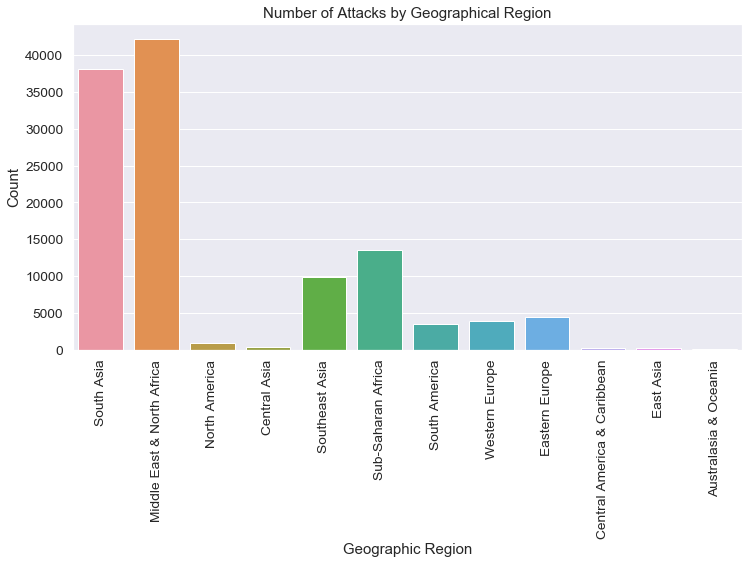

In [240]:
# Setting style for plots
sns.set_style('darkgrid')
sns.set(font_scale = 1.25)

# Plotting barplot
ax = plt.figure(figsize = (12, 6))
ax = sns.countplot(data = explore_df, x = 'region_txt')
ax.set_title('Number of Attacks by Geographical Region')
ax.set_xlabel('Geographic Region')
ax.set_ylabel('Count')
plt.xticks(rotation = 90);

<div class="alert alert-info" role="alert">
  The plot above shows that an overwhelming majority of terrorist attacks occur in the <b>Middle East/North Africa and South Asia. </b> 
</div>

#### Fig 2.  Attack Type

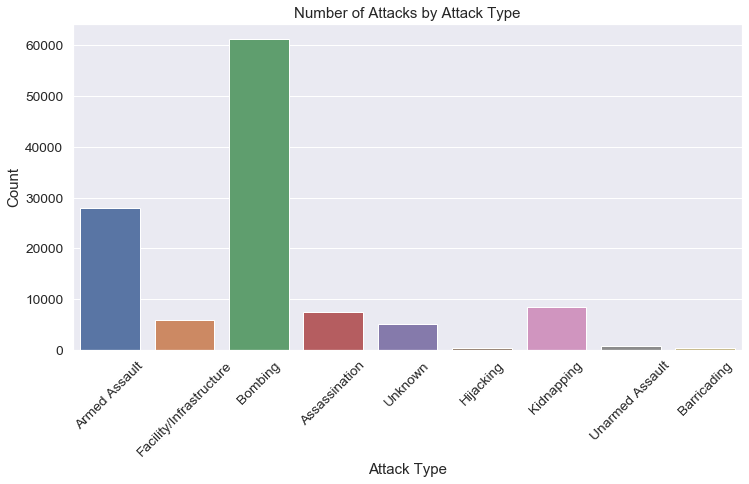

In [239]:
# Plotting barplot

ax = plt.figure(figsize = (12, 6))
ax = sns.countplot(data = explore_df, x = 'attacktype1_txt')
ax.set_title('Number of Attacks by Attack Type')
ax.set_ylabel('Count')
ax.set_xlabel('Attack Type')
plt.xticks(rotation = 45);

<div class="alert alert-info" role="alert">
  The plot above shows that an most attempted terrorist attacks are either <b>bombings or armed assaults. </b> 
</div>

#### Fig 3.  Month of Attack

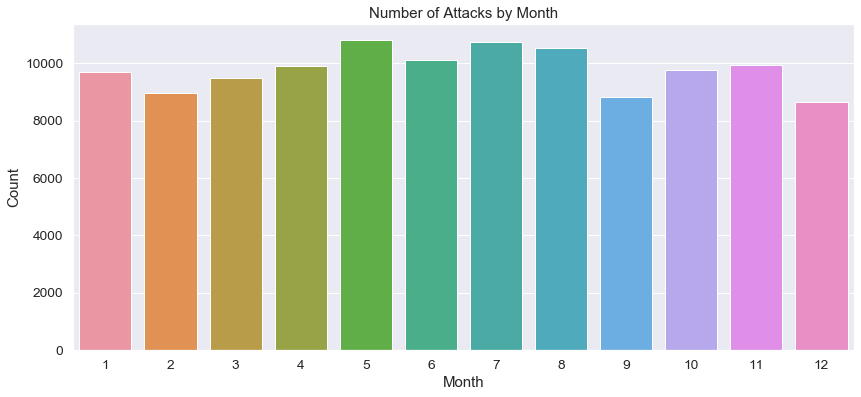

In [238]:
# Plotting barplot

ax = plt.figure(figsize = (14, 6))
ax = sns.countplot(data = df, x = 'imonth')
ax.set_xlabel('Month')
ax.set_ylabel('Count')
ax.set_title('Number of Attacks by Month');

<div class="alert alert-info" role="alert">
  This plot indicates that the time of year doesn't seem to have much bearing on whether or not a terrorist attack may occur. 
</div>

#### Fig. 4 - Target Type

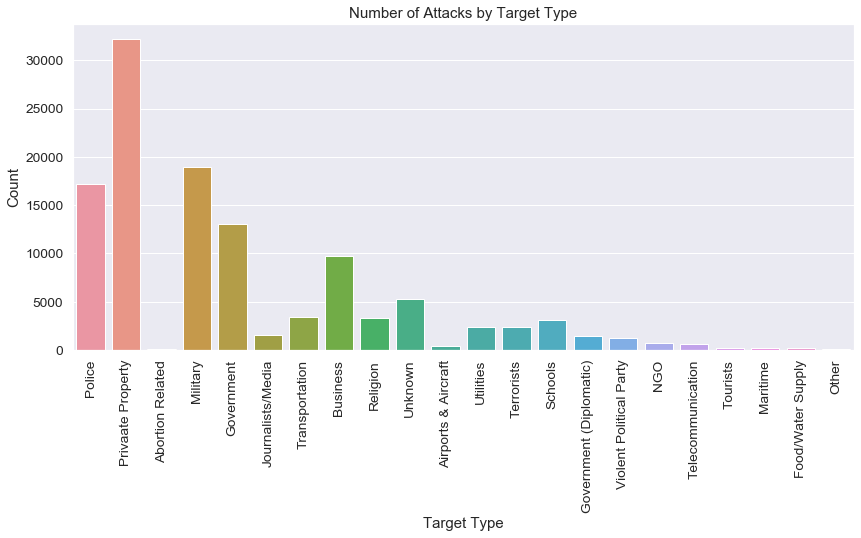

In [244]:
ax = plt.figure(figsize = (14, 6))
ax = sns.countplot(data = df, x = 'targtype1_txt')
ax.set_xlabel('Target Type')
ax.set_ylabel('Count')
ax.set_title('Number of Attacks by Target Type');
plt.xticks(rotation = 90);

<div class="alert alert-info" role="alert">
  The plot above shows that the top targets for a terrorist attack are <b>Private Property, Military, Police, Government, and Business.</b>
</div>

## Model

### Logistic Regression

#### Base Model

In [95]:
# Creatomg a baseline logistic regression model

logreg = LogisticRegression(class_weight = 'balanced')
logreg.fit(X_train_trans_df, y_train)

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


LogisticRegression(class_weight='balanced')

                 Classification Report
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.38      0.82      0.52      3628
           1       0.97      0.81      0.89     25718

    accuracy                           0.81     29346
   macro avg       0.68      0.82      0.70     29346
weighted avg       0.90      0.81      0.84     29346



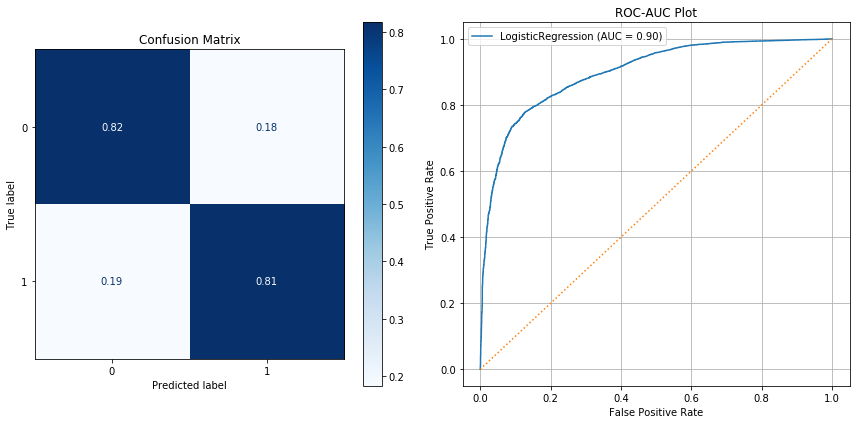

In [96]:
# Evaluating the logistic regression model

evaluate_model(logreg, X_test_trans_df, y_test)

#### Model with GridSearchCV

In [97]:
# Finding the best hyperparameters using GridSearchCV

params = {'class_weight': ['balanced'],
          'solver': ['lbfgs', 'liblinear'],
          'C': [1.0, 3.0, 5.0]}
grid = GridSearchCV(estimator = LogisticRegression(), param_grid = params, cv = 3, n_jobs = -1)
grid.fit(X_train_trans_df, y_train)

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


GridSearchCV(cv=3, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [1.0, 3.0, 5.0], 'class_weight': ['balanced'],
                         'solver': ['lbfgs', 'liblinear']})

In [98]:
# Taking a look at the best paramaters.

print(grid.best_estimator_.get_params())

{'C': 1.0, 'class_weight': 'balanced', 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


In [99]:
# Fitting a new model with the gridsearchcv parameters. 

logreg2 = LogisticRegression(class_weight = 'balanced',
                             C = 1.0,
                             solver = 'lbfgs')
logreg2.fit(X_train_trans_df, y_train)

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


LogisticRegression(class_weight='balanced')

                 Classification Report
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.38      0.82      0.52      3628
           1       0.97      0.81      0.89     25718

    accuracy                           0.81     29346
   macro avg       0.68      0.82      0.70     29346
weighted avg       0.90      0.81      0.84     29346



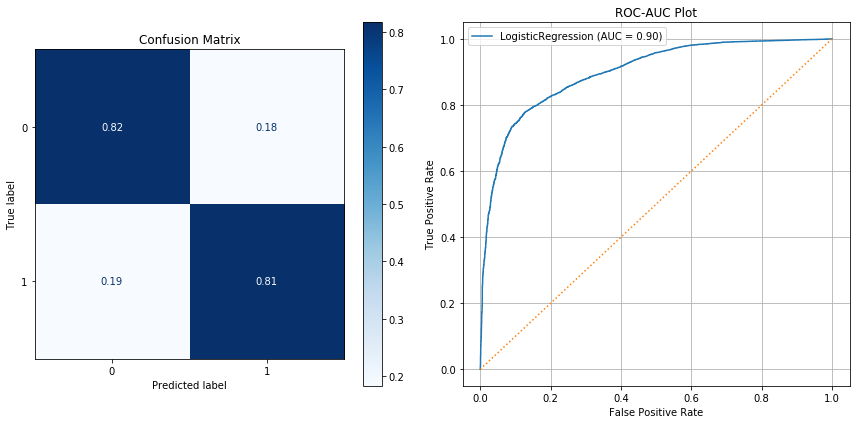

In [100]:
# Evaluating the logistic regression model

evaluate_model(logreg2, X_test_trans_df, y_test)

### Decision Tree

#### Base Model

In [101]:
# Fitting a baseline Decision Tree model

decision_tree = DecisionTreeClassifier(class_weight = 'balanced')
decision_tree.fit(X_train_trans_df, y_train)

DecisionTreeClassifier(class_weight='balanced')

                 Classification Report
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.78      0.78      0.78      3628
           1       0.97      0.97      0.97     25718

    accuracy                           0.94     29346
   macro avg       0.87      0.87      0.87     29346
weighted avg       0.94      0.94      0.94     29346



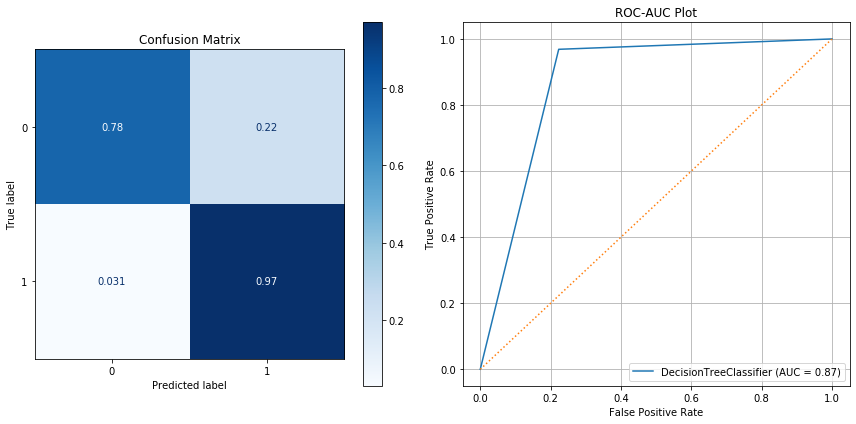

In [102]:
# Evaluating model performance

evaluate_model(decision_tree, X_test_trans_df, y_test)

#### Model with GridSearchCV

In [103]:
# Finding the best hyperparameters

params = {'class_weight': [None, 'balanced'],
          'criterion': ['gini', 'entropy'],
          'max_depth': [1, 3, 5], 
          'min_samples_leaf': [1, 3, 5]}
grid = GridSearchCV(estimator = DecisionTreeClassifier(), param_grid = params, cv = 3, n_jobs = -1)
grid.fit(X_train_trans_df, y_train)

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'class_weight': [None, 'balanced'],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [1, 3, 5],
                         'min_samples_leaf': [1, 3, 5]})

In [104]:
# Checking out the gridsearch results

print(grid.best_estimator_.get_params())

{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 5, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 5, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'presort': 'deprecated', 'random_state': None, 'splitter': 'best'}


In [105]:
# Fitting a second model with the new hyperparamaters

decision_tree2 = DecisionTreeClassifier(class_weight = 'balanced', 
                                        criterion = 'entropy', 
                                        max_depth = 5, 
                                        min_samples_leaf = 5)
decision_tree2.fit(X_train_trans_df, y_train)

DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=5, min_samples_leaf=5)

                 Classification Report
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.60      0.90      0.72      3628
           1       0.99      0.91      0.95     25718

    accuracy                           0.91     29346
   macro avg       0.79      0.91      0.83     29346
weighted avg       0.94      0.91      0.92     29346



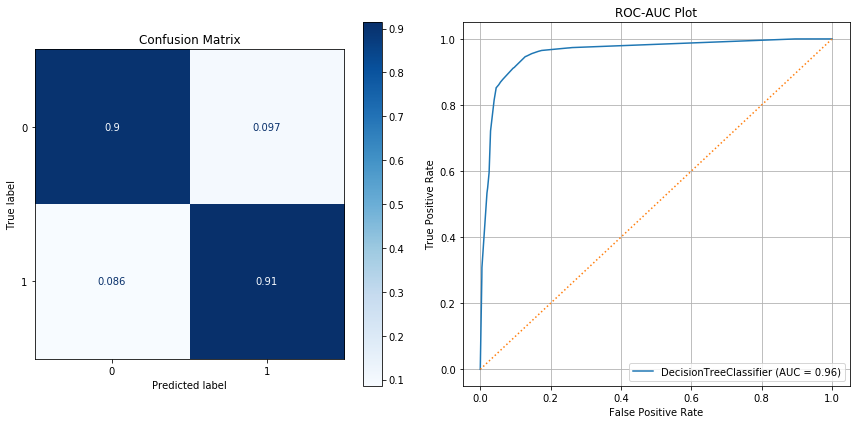

In [106]:
# Evaluating model performance

evaluate_model(decision_tree2, X_test_trans_df, y_test)

### Random Forest

#### Base Model

In [107]:
# Fitting a base random forest model

random_forest = RandomForestClassifier(class_weight = 'balanced')
random_forest.fit(X_train_trans_df, y_train)

RandomForestClassifier(class_weight='balanced')

                 Classification Report
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.90      0.77      0.83      3628
           1       0.97      0.99      0.98     25718

    accuracy                           0.96     29346
   macro avg       0.93      0.88      0.90     29346
weighted avg       0.96      0.96      0.96     29346



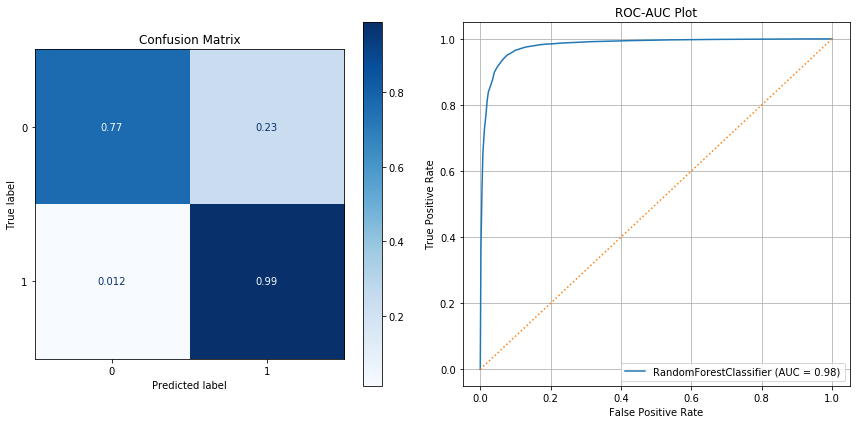

In [108]:
# Evaluating the model performance.

evaluate_model(random_forest, X_test_trans_df, y_test)

#### Model with GridSearchCV

In [109]:
# Finding the best hyperparameters 

params = {'class_weight': [None, 'balanced'],
          'criterion': ['gini', 'entropy'],
          'max_depth': [1, 3, 5], 
          'min_samples_leaf': [1, 5, 10]}
grid = GridSearchCV(estimator = RandomForestClassifier(), param_grid = params, cv = 3, n_jobs = -1)
grid.fit(X_train_trans_df, y_train)

GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'class_weight': [None, 'balanced'],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [1, 3, 5],
                         'min_samples_leaf': [1, 5, 10]})

In [110]:
# Checking out the best hyperparameters.

print(grid.best_estimator_.get_params())

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 5, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 5, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


In [111]:
# Fitting a new model with the best parameters.

random_forest2 = RandomForestClassifier(class_weight = 'balanced', 
                                        criterion = 'entropy', 
                                        max_depth = 5, 
                                        min_samples_leaf = 10)
random_forest2.fit(X_train_trans_df, y_train)

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=5, min_samples_leaf=10)

                 Classification Report
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.55      0.89      0.68      3628
           1       0.98      0.90      0.94     25718

    accuracy                           0.90     29346
   macro avg       0.77      0.89      0.81     29346
weighted avg       0.93      0.90      0.91     29346



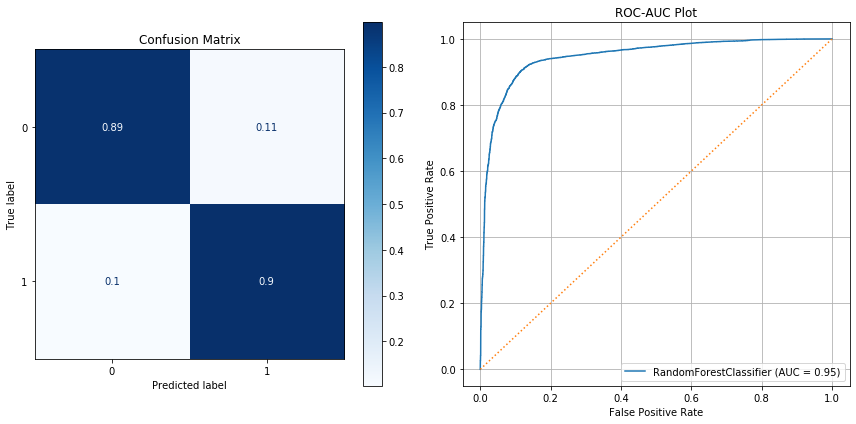

In [112]:
# Evaluating the model's performance.

evaluate_model(random_forest2, X_test_trans_df, y_test)

### XGBoost

#### Base Model

In [113]:
# Fitting a base XGBoost model.

xgboost = xgb.XGBClassifier()
xgboost.fit(X_train_trans_df, y_train)

XGBClassifier()

                 Classification Report
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.81      0.80      0.80      3628
           1       0.97      0.97      0.97     25718

    accuracy                           0.95     29346
   macro avg       0.89      0.89      0.89     29346
weighted avg       0.95      0.95      0.95     29346



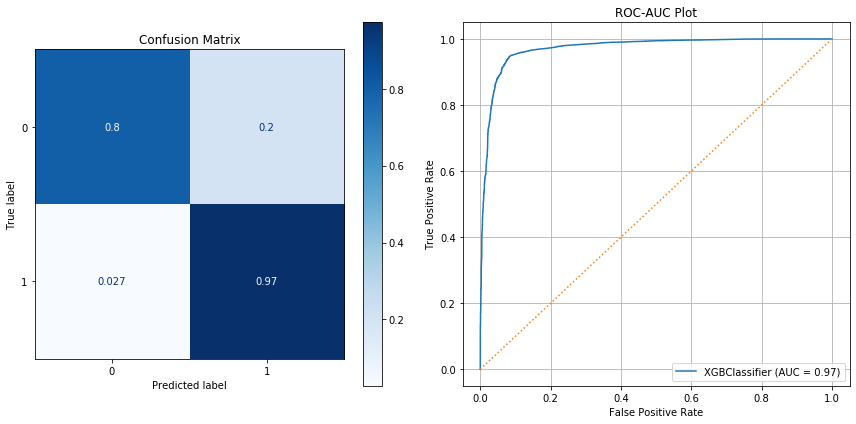

In [114]:
# Evaluating model performance.

evaluate_model(xgboost, X_test_trans_df, y_test)

#### Model with GridsearchCV

In [115]:
# Finding the best hyperparameters.

params = {'gamma': [0.5, 1, 2, 5],
          'min_child_weight': [1, 5, 10],
          'max_depth': [1, 3, 5]}
grid = GridSearchCV(estimator = xgb.XGBClassifier(), param_grid = params, cv = 3, n_jobs = -1)
grid.fit(X_train_trans_df, y_train)

GridSearchCV(cv=3, estimator=XGBClassifier(), n_jobs=-1,
             param_grid={'gamma': [0.5, 1, 2, 5], 'max_depth': [1, 3, 5],
                         'min_child_weight': [1, 5, 10]})

In [116]:
# Checking out the gridsearch results.

print(grid.best_estimator_.get_params())

{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 1, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 100, 'n_jobs': 1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1}


In [117]:
# Fitting a second model using the new hyperparameters.  

xgboost2 = xgb.XGBClassifier(gamma = 1,
                             min_child_weight = 1,  
                             max_depth = 5)
xgboost2.fit(X_train_trans_df, y_train)

XGBClassifier(gamma=1, max_depth=5)

                 Classification Report
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.84      0.84      0.84      3628
           1       0.98      0.98      0.98     25718

    accuracy                           0.96     29346
   macro avg       0.91      0.91      0.91     29346
weighted avg       0.96      0.96      0.96     29346



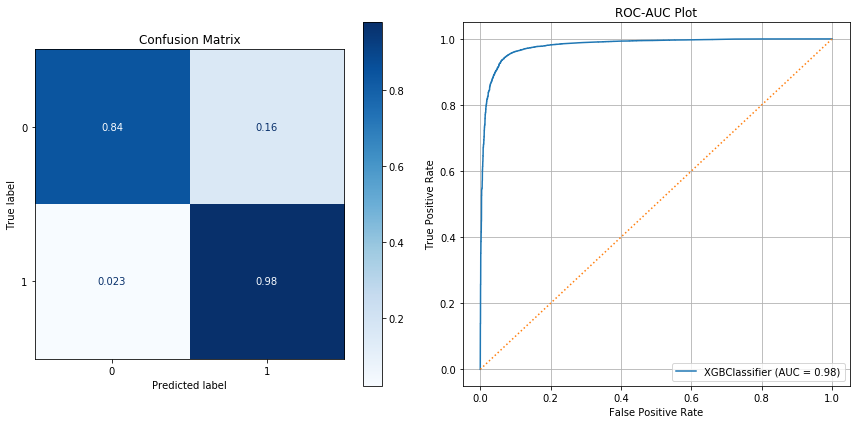

In [118]:
# Evaluating model performance. 

evaluate_model(xgboost2, X_test_trans_df, y_test)

### Stacking Ensemble

 <div class="alert alert-info" role="alert">
In order to get an even more accurate model, we can stack the best of the previous models together in an ensemble.  
    </div>

In [119]:
# Taking all the best models and adding them to a stacking ensemble.  

estimators = [('dt', DecisionTreeClassifier(class_weight = 'balanced', 
                                            criterion = 'entropy',
                                            max_depth = 5, 
                                            min_samples_leaf = 5)),
              ('rf', RandomForestClassifier(class_weight = 'balanced', 
                                            criterion = 'entropy', 
                                            max_depth = 5, 
                                            min_samples_leaf = 10)), 
              ('xg', xgb.XGBClassifier(gamma = 1,
                                       min_child_weight = 1,  
                                       max_depth = 5))]

stack = StackingClassifier(estimators = estimators, cv = 3, n_jobs = -1)
stack.fit(X_train_trans_df, y_train)

StackingClassifier(cv=3,
                   estimators=[('dt',
                                DecisionTreeClassifier(class_weight='balanced',
                                                       criterion='entropy',
                                                       max_depth=5,
                                                       min_samples_leaf=5)),
                               ('rf',
                                RandomForestClassifier(class_weight='balanced',
                                                       criterion='entropy',
                                                       max_depth=5,
                                                       min_samples_leaf=10)),
                               ('xg', XGBClassifier(gamma=1, max_depth=5))],
                   n_jobs=-1)

                 Classification Report
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.84      0.83      0.83      3628
           1       0.98      0.98      0.98     25718

    accuracy                           0.96     29346
   macro avg       0.91      0.90      0.90     29346
weighted avg       0.96      0.96      0.96     29346



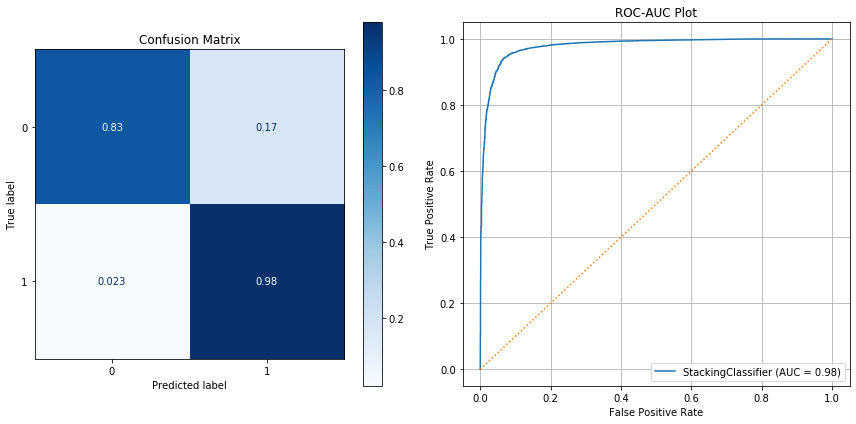

In [120]:
# Evaluating model performance.  

evaluate_model(stack, X_test_trans_df, y_test)

### Results

In [121]:
# Printing out the results in terms of the recall score.  

print('Recall Scores for Each Model')
print('------------------------------')
print('Logistic Regression: ', round(get_recall(logreg2, X_test_trans_df, y_test), 2))
print('Decision Tree: ', round(get_recall(decision_tree2, X_test_trans_df, y_test), 2))
print('Random Forest: ', round(get_recall(random_forest2, X_test_trans_df, y_test), 2))
print('XGBoost: ', round(get_recall(xgboost2, X_test_trans_df, y_test), 2))
print('Stacking Classifier: ', round(get_recall(stack, X_test_trans_df, y_test), 2))

Recall Scores for Each Model
------------------------------
Logistic Regression:  0.81
Decision Tree:  0.91
Random Forest:  0.9
XGBoost:  0.98
Stacking Classifier:  0.98


In [122]:
models = [logreg2, decision_tree2, random_forest2, xgboost2, stack]

get_score_summary(models, X_test_trans_df, y_test)

,0,1,2,3,4
0,"{'precision': 0.3833419555095706, 'recall': 0....","{'precision': 0.5968300236837311, 'recall': 0....","{'precision': 0.5501535312180144, 'recall': 0....","{'precision': 0.8359396433470507, 'recall': 0....","{'precision': 0.8368142578668895, 'recall': 0...."
1,"{'precision': 0.969279170907745, 'recall': 0.8...","{'precision': 0.9852454206312613, 'recall': 0....","{'precision': 0.9828393800034065, 'recall': 0....","{'precision': 0.97739387572468, 'recall': 0.97...","{'precision': 0.9758105222286935, 'recall': 0...."
accuracy,0.814898,0.912595,0.896408,0.959824,0.958802
macro avg,"{'precision': 0.6763105632086578, 'recall': 0....","{'precision': 0.7910377221574962, 'recall': 0....","{'precision': 0.7664964556107104, 'recall': 0....","{'precision': 0.9066667595358653, 'recall': 0....","{'precision': 0.9063123900477914, 'recall': 0...."
weighted avg,"{'precision': 0.8968406710282187, 'recall': 0....","{'precision': 0.9372262336849777, 'recall': 0....","{'precision': 0.9293471064603887, 'recall': 0....","{'precision': 0.9599061106096374, 'recall': 0....","{'precision': 0.9586266318482455, 'recall': 0...."


## Interpret

In [252]:
features_dict = {'Features': X_train_trans_df.columns,
                 'Importance': xgboost2.feature_importances_}

feature_importance = pd.DataFrame(features_dict, columns = ['Features','Importance'])

print(feature_importance.shape)
feature_importance

(139, 2)


,Features,Importance
0,iyear,0.010853
1,imonth,0.001692
2,iday,0.001694
3,extended,0.006108
4,latitude,0.003892
...,...,...
134,weaptype1_txt_Vehicle,0.000000
135,propextent_txt_Catastrophic,0.000000
136,propextent_txt_Major,0.000000
137,propextent_txt_Minor,0.001268


In [253]:
# Removing all features that were reduced to a 0 importance.

for i in feature_importance['Importance']:
    if i == 0:
        feature_importance['Importance'].replace(i, np.nan, inplace = True)
        
feature_importance.dropna(inplace = True)
print(feature_importance.shape)

(85, 2)


In [254]:
# Checking  that this worked

feature_importance

,Features,Importance
0,iyear,0.010853
1,imonth,0.001692
2,iday,0.001694
3,extended,0.006108
4,latitude,0.003892
...,...,...
128,weaptype1_txt_Incendiary,0.003572
129,weaptype1_txt_Melee,0.000660
133,weaptype1_txt_Unknown,0.022941
137,propextent_txt_Minor,0.001268


In [264]:
feature_importance.sort_values(by = ['Importance'], ascending = False, inplace = True)
feature_importance.head(10)

,Features,Importance
72,targtype1_txt_Unknown,0.183279
26,ishostkid,0.106155
24,property,0.101152
18,nkill,0.072061
45,attacktype1_txt_Assassination,0.070749
21,nwound,0.039244
20,nkillter,0.037638
23,nwoundte,0.030587
10,crit3,0.026291
133,weaptype1_txt_Unknown,0.022941


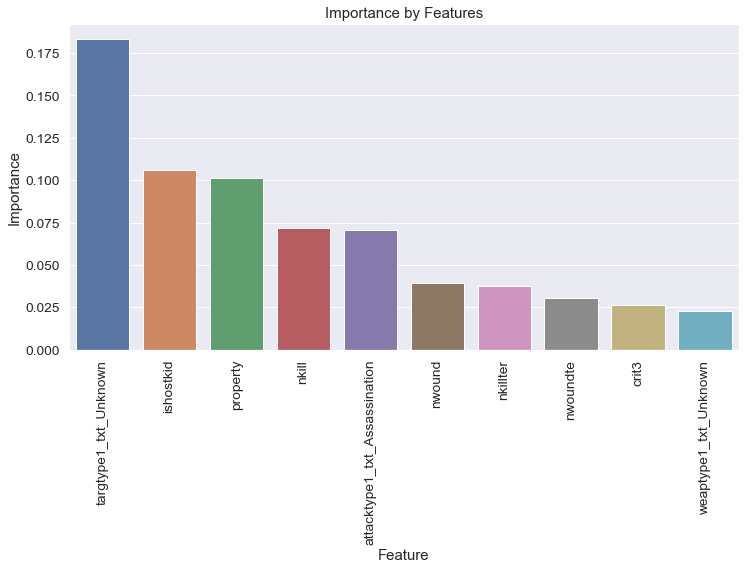

In [265]:
# Plotting feature importances

ax = plt.figure(figsize = (12, 6))
ax = sns.barplot(data = feature_importance.head(10), x = 'Features', y = 'Importance')
ax.set_title('Importance by Features')
ax.set_xlabel('Feature')
ax.set_ylabel('Importance')
plt.xticks(rotation = 90);

### SHAP

In [190]:
# Setting up SHAP

X_shap = shap.sample(X_test_trans_df, 100)
explainer = shap.TreeExplainer(xgboost2)
shap_values = explainer.shap_values(X_shap)

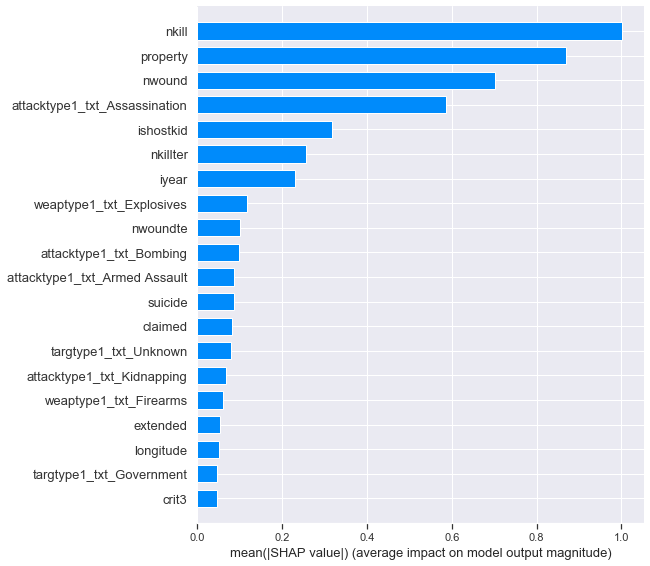

In [270]:
# Plotting a SHAP summary plot

fig = shap.summary_plot(shap_values, X_shap, plot_type="bar")

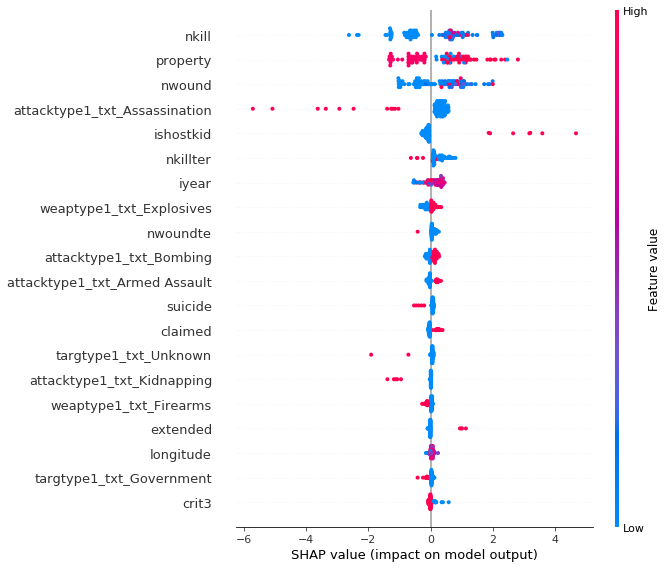

In [192]:
# Plotting a different type of SHAP summary plot

shap.summary_plot(shap_values, X_shap)

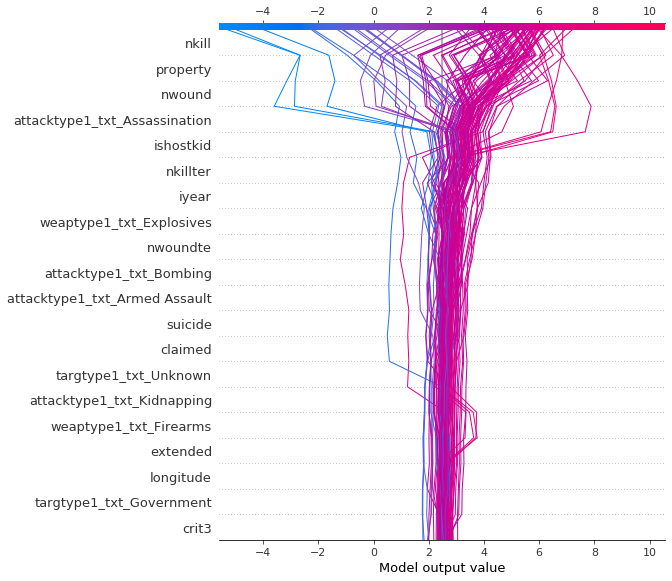

In [193]:
# Plotting a SHAP decision plot

expected_value = explainer.expected_value
shap.decision_plot(expected_value, shap_values, X_shap)

In [194]:
# Creating a SHAP force plot

shap.force_plot(explainer.expected_value, shap_values[0,:], X_shap.iloc[0,:])

In [195]:
# Plotting a different type of SHAP force plot

shap.force_plot(expected_value, shap_values, X_shap, link = 'logit')

In [196]:
# Creating interaction values 

shap_interaction_values = explainer.shap_interaction_values(X_shap)

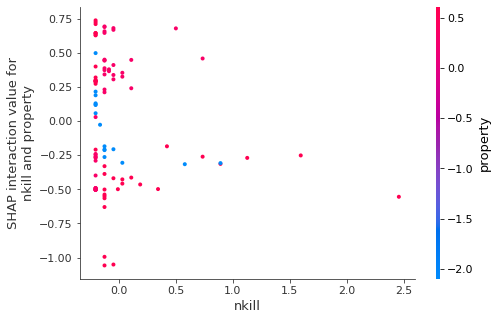

In [197]:
# Plotting a shap dependence plot

shap.dependence_plot(('nkill', 'property'), shap_interaction_values, X_shap)

 <div class="alert alert-info" role="alert">
    <b><u>Top 5 Feature Importances from Sklearn </u></b>- targtype1_txt_Unknown, ishostkid, property, nkill, attacktype1_txt_Assassination<br><br>
<b><u>Top 5 Feature Importances from SHAP</u></b> - nkill, property, nwound, attacktype1_txt_Assassination, ishostkid<br><br>
    <b><u> Overlapping Important Features </u></b>- nkill, ishostkid, attacktype1_txt_Assassination, property

 </div>

### Results

<div class="alert alert-success" role="alert">
    <b><u><center>Overlapping Important Features:</center></u></b><br><br>
1. <b><u>nkill </u></b>- Total Number of Fatalities - High numbers of fatalities positively affect the success and low numbers of fatalities negatively affect the success of attack.<br><br>
2. <b><u>ishostkid</u></b> - Hostages or Kidnapping Victims - Very positively affects the success of attack.<br><br>
3. <b><u>attacktype1_txt_Assassination</u></b> - Attempted Assassination - Very negatively affects the success of attack.<br><br>
    4. <b><u>property</u></b> - Property Damage (Evidence of property damage from attack) - Slightly positively affects the success of attack.
    </div>

## Conclusion

Terrorism is one of the main global threats of our era.  In the interest of national security, we have conducted a thorough analysis of what makes a terrorist attack successful. By knowing the patterns, strenghts and weakness of terrorists and terrorist organizations, we can be more prepared to prevent new attacks in the future.  Using the OSEMN data science process, we used various machine learning algorithms to determine the impact that each feature has on the success of a terrorist attack.  Models used within this notebook are Logistic Regression, Decision Tree, Random Forest, XGBoost and a Stacking Classifier that used severeal of these models in tandem.  

 <div class="alert alert-info" role="alert">
<center><b><u>Defining "Success"</u></b></center>
<u>According to the Global Terrorist Database: </u><br>
Success of a terrorist strike is defined according to the tangible effects of the attack.
Success is not judged in terms of the larger goals of the perpetrators. For example, a
bomb that exploded in a building would be counted as a success even if it did not
succeed in bringing the building down or inducing government repression. <br><br>
The definition of a successful attack depends on the type of attack. Essentially, the
key question is whether or not the attack type took place. If a case has multiple
attack types, it is successful if any of the attack types are successful, with the
exception of assassinations, which are only successful if the intended target is killed.
    </div>

<b>Throughout the course of this notebook, we have determined the following features as the most important in terms of a terrorist attack being successful: </b><br><br>
<u>From Modeling</u>
 - 1. Total Number of Fatalities - High counts positively affect success, low counts negatively affect success.
 - 2. Hostage/Kidnapping - Very positively affects the success of an attack.
 - 3. Assasination Attempt - Very negatively affects the success of an attack.
 - 4. Property Damage - Evidence of property damage from attack positvely affects the success.  <br>
 
<u>From Data Exploration</u>
 - An overwhelming majority of terrorist attacks occur in the Middle East/North Africa and South Asia. 
 - Most attempted terrorist attacks are either bombings or armed assaults.


### Reccomendations

<b>Based on the results of this analysis, we can make the following recommnedations: </b>
 - Maintain high levels of intel and security in the Middle East and South Asia.
 - Develop better methods and/or technology for bomb detection and disarmament.  
 - Focus intel on target areas that have the highest concentration of people.
 - Increase security for high level targets for potential kidnapping or hostage situations.  
 

### Future Work

<b>With more time, we can gain even more insight into what can make a terrorist attack successful in order to create better security measures.  </b>

 - <b><u>Time:</u></b>  We can increase the range of years of the data in our analysis.  For example, the full dataset ranges from 1970 to 2017.  
 - <b><u>Models:</u></b>  We can increase the size and complexiy of our models in order to increase the accuracy of our results. 
 - <b><u>Data:</u></b>  We can research and compile additonal data from other resources for a more well rounded dataset.  

<center><b><i> Thank you. <i></b></center>